<H1>GROUP 13 - SALES VOLUME PREDICTIVE MODELLING</H1>

Table of Contents:
- [Data Loading](#data)
    - [Inspect Data - Transaction](#tr)
    - [Inspect Data - Product](#pr)
    - [Inspect Data - Causal Data](#cau)
- [Data Preprocessing](#preprocess)
    - [Join Dataset](#join)
    - [Handling Missing Value](#fillna)
    - [Feature Engineering](#fe)
    - [Variable Transformation](#ft)
- [Exploratory Data Analysis](#eda)
- [Machine Learning Workflow](#split)
    - [Linear Regression](#lr)
    - [Random Forest](#rf)
    - [Performance Comparison](#pc)
- [Machine Learning Optimization](#mlop)
- [Conclusion](#conclusion)

Additional Note : It takes about 1hr 30 mins to run the whole code (depending on computing resource)

In [70]:
# Import Necessary Library
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

<a id="data"></a>
<h2>Data Loading</h2>
Loading data and inspect on data type and missing value:

- [Inspect Data - Transaction](#tr)
- [Inspect Data - Product](#pr)
- [Inspect Data - Causal Data](#cau)

<a id="tr"></a>
<h3>Transaction Data</h3>

Transaction Data serve as the main table


In [71]:
# Load Data
transaction_data = pd.read_csv('transaction_data.csv')
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      int64  
 1   BASKET_ID          int64  
 2   DAY                int64  
 3   PRODUCT_ID         int64  
 4   QUANTITY           int64  
 5   SALES_VALUE        float64
 6   STORE_ID           int64  
 7   RETAIL_DISC        float64
 8   TRANS_TIME         int64  
 9   WEEK_NO            int64  
 10  COUPON_DISC        float64
 11  COUPON_MATCH_DISC  float64
dtypes: float64(4), int64(8)
memory usage: 237.6 MB


In [72]:
# Inspect on missing value
transaction_data.isnull().sum()

household_key        0
BASKET_ID            0
DAY                  0
PRODUCT_ID           0
QUANTITY             0
SALES_VALUE          0
STORE_ID             0
RETAIL_DISC          0
TRANS_TIME           0
WEEK_NO              0
COUPON_DISC          0
COUPON_MATCH_DISC    0
dtype: int64

<a id="pr"></a>
<h3>Product Data</h3>

Product Data serve as the lookup table to find more detail information about the product being sold


In [73]:
# Load Data
product = pd.read_csv('product.csv')
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PRODUCT_ID            92353 non-null  int64 
 1   MANUFACTURER          92353 non-null  int64 
 2   DEPARTMENT            92353 non-null  object
 3   BRAND                 92353 non-null  object
 4   COMMODITY_DESC        92353 non-null  object
 5   SUB_COMMODITY_DESC    92353 non-null  object
 6   CURR_SIZE_OF_PRODUCT  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [74]:
# Inspect on missing values
product.isnull().sum()

PRODUCT_ID              0
MANUFACTURER            0
DEPARTMENT              0
BRAND                   0
COMMODITY_DESC          0
SUB_COMMODITY_DESC      0
CURR_SIZE_OF_PRODUCT    0
dtype: int64

<a id="cau"></a>
<h3>Causal Data</h3>

Causal Data serve as the lookup table to find more detail information about the product placement and brochure placement


In [75]:
# Load Data
causal_data = pd.read_csv('causal_data.csv')
causal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36786524 entries, 0 to 36786523
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   PRODUCT_ID  int64 
 1   STORE_ID    int64 
 2   WEEK_NO     int64 
 3   display     object
 4   mailer      object
dtypes: int64(3), object(2)
memory usage: 1.4+ GB


In [76]:
# Inspect on Missing Value
causal_data.isnull().sum()

PRODUCT_ID    0
STORE_ID      0
WEEK_NO       0
display       0
mailer        0
dtype: int64

<a id="preprocessing"></a>
<h2>Data Preprocessing</h2>

After loading the necessary data, we can see there is no missing values within each data.
In this section, we will preprocess the data before doing in-depth analysis.
- [Join Dataset](#join)
- [Handling Missing Value](#fillna)
- [Feature Engineering](#fe)
- [Variable Transformation](#ft)



<a id="join"></a>
<h3>Join Dataset</h3>

We will join the dataset to combine the information. Transaction data serves as the main table and the key columns used in the join based on the dataset entity diagram relationship.

In [77]:
# Join Data Transaction and Causal - Joined Key based on identifier from data description
df = pd.merge(transaction_data, causal_data, on=['PRODUCT_ID', 'WEEK_NO', 'STORE_ID'], how='left')

# Join Data Transaction Causal + Product Information - Joined Key based on identifier from data description
df = pd.merge(df, product, on=['PRODUCT_ID'], how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2596590 entries, 0 to 2596589
Data columns (total 20 columns):
 #   Column                Dtype  
---  ------                -----  
 0   household_key         int64  
 1   BASKET_ID             int64  
 2   DAY                   int64  
 3   PRODUCT_ID            int64  
 4   QUANTITY              int64  
 5   SALES_VALUE           float64
 6   STORE_ID              int64  
 7   RETAIL_DISC           float64
 8   TRANS_TIME            int64  
 9   WEEK_NO               int64  
 10  COUPON_DISC           float64
 11  COUPON_MATCH_DISC     float64
 12  display               object 
 13  mailer                object 
 14  MANUFACTURER          int64  
 15  DEPARTMENT            object 
 16  BRAND                 object 
 17  COMMODITY_DESC        object 
 18  SUB_COMMODITY_DESC    object 
 19  CURR_SIZE_OF_PRODUCT  object 
dtypes: float64(4), int64(9), object(7)
memory usage: 396.2+ MB


In [78]:
# Change identifier columns into object instead of numerical variables - assigning apporpritae data type
identifiers = ['PRODUCT_ID','BASKET_ID','MANUFACTURER','household_key','STORE_ID']
for ids in identifiers:
    df[ids] = df[ids].astype('object')

<a id="fillna"></a>
<h3>Handling Missing Value</h3>

After joining, data might contains missing value due to pairs not found. 


In [79]:
# Inspect missing values after joining dataset
df.isna().sum().sort_values(ascending=False)

mailer                  2031958
display                 2031958
household_key                 0
BASKET_ID                     0
SUB_COMMODITY_DESC            0
COMMODITY_DESC                0
BRAND                         0
DEPARTMENT                    0
MANUFACTURER                  0
COUPON_MATCH_DISC             0
COUPON_DISC                   0
WEEK_NO                       0
TRANS_TIME                    0
RETAIL_DISC                   0
STORE_ID                      0
SALES_VALUE                   0
QUANTITY                      0
PRODUCT_ID                    0
DAY                           0
CURR_SIZE_OF_PRODUCT          0
dtype: int64

There is a significant proportion of the data not finding the information on display and mailer information. We will assume that the product was not on special display or special mailer and fill the value into '0'

In [80]:
# Fill in missing values
df.fillna('0', inplace=True)

<a id="fe"></a>
<h3>Feature Engineering</h3>

On this step, we will look at:
- Data Distribution
- Removing any invalid data
- Deriving new feature to reduce dimensionality
- Creating new feature to give more information about the data

In [81]:
# Descriptive Statistics for numerical variables
num_vars = [col for col in df.columns if df[col].dtype != 'object']

df[num_vars].describe()

DAY      QUANTITY   SALES_VALUE   RETAIL_DISC    TRANS_TIME  \
count  2.596590e+06  2.596590e+06  2.596590e+06  2.596590e+06  2.596590e+06   
mean   3.887878e+02  1.003960e+02  3.103663e+00 -5.389362e-01  1.561579e+03   
std    1.897111e+02  1.153247e+03  4.181843e+00  1.249464e+00  3.998420e+02   
min    1.000000e+00  0.000000e+00  0.000000e+00 -1.800000e+02  0.000000e+00   
25%    2.290000e+02  1.000000e+00  1.290000e+00 -6.900000e-01  1.308000e+03   
50%    3.900000e+02  1.000000e+00  2.000000e+00 -1.000000e-02  1.613000e+03   
75%    5.530000e+02  1.000000e+00  3.490000e+00  0.000000e+00  1.843000e+03   
max    7.110000e+02  8.963800e+04  8.400000e+02  3.990000e+00  2.359000e+03   

            WEEK_NO   COUPON_DISC  COUPON_MATCH_DISC  
count  2.596590e+06  2.596590e+06       2.596590e+06  
mean   5.622601e+01 -1.642829e-02      -2.917600e-03  
std    2.710081e+01  2.169048e-01       3.968352e-02  
min    1.000000e+00 -5.593000e+01      -7.700000e+00  
25%    3.300000e+01  0.000000e+00       0.000000e+00  
50%    5.600000e+01  0.000000e+00       0.000000e+00  
75%    8.000000e+01  0.000000e+00       0.000000e+00  
max    1.020000e+02  0.000000e+00       0.000000e+00

In [82]:
#Descriptive Statistics for categorical variables
cat_vars = [col for col in df.columns if df[col].dtype == 'object']

df[cat_vars].describe()

household_key    BASKET_ID  PRODUCT_ID  STORE_ID  display   mailer  \
count         2596590      2596590     2596590   2596590  2596590  2596590   
unique           2500       276484       92339       582       10       10   
top               718  30983766334     1082185       367        0        0   
freq             6851          168       29778     75644  2322939  2181583   

        MANUFACTURER DEPARTMENT     BRAND COMMODITY_DESC  \
count        2596590    2596590   2596590        2596590   
unique          6476         44         2            308   
top               69    GROCERY  National    SOFT DRINKS   
freq          732064    1646473   1850291         117773   

           SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
count                 2596590              2596590  
unique                   2383                 4345  
top     FLUID MILK WHITE ONLY                       
freq                    65805               466774

From the descriptive statistics of univariate analysis above, we can take notes on:
- Day of Transaction 1 to 711
- The presence of 0 value in quantity -> this might be recorded due to void transaction, returning items, To get the real transaction data we will filter the data where quantity > 0
- The presence of 0 value in sales value -> this might be recorded due to void transaction, returning items, or free items. To get the real transaction data we will filter the data > 0
- Coupon match disc signify if the transaction using redeemed coupon or not -> we can generate new feature to indicate this information
- There were 2500 households, 276484 collections of transaction was performed, 92339 unique products being sold from 6476 manufacturers in 582 stores
- High cardinality in department, commodity desc and sub commity description -> need to use ordinal encoder instead of one hot encoding to reduce the dimension
- Use one-hot encoding and dropping one column to signify the information on display and mailer
- Curr size of products does not contain a lot of useful informaiton therefore will not be use during training
- There is no information about the store, we will classify the store based on the derivations of transaction data


In [83]:
#Remove rows where quantity==0
print(f"Removing {len(df[df['QUANTITY']==0])} rows due to quantity == 0")

df = df[df['QUANTITY']>0]

#Remove rows where sales value ==0
print(f"Removing {len(df[df['SALES_VALUE']==0])} rows due to SALES_VALUE == 0")

df = df[df['SALES_VALUE']>0]

# Print number of data after removing rows
print(f' Number of data: {len(df)}')


Removing 14468 rows due to quantity == 0
Removing 4451 rows due to SALES_VALUE == 0
 Number of data: 2577671


In [84]:
# Calculation Real Sales Value without discount
df['REAL_SALES_VALUE'] = (df['SALES_VALUE'] + abs(df['RETAIL_DISC']) + abs(df['COUPON_DISC'])+ abs(df['COUPON_MATCH_DISC']))

# Product Price
df['PRODUCT_PRICE'] = df['REAL_SALES_VALUE']/df['QUANTITY']

# Deriving new feature to reduce the discount flag information
# Flag Indicator if the coupon has been used
df['COUPON_FLAG'] = df['COUPON_MATCH_DISC'].apply(lambda x: 1 if x < 0 else 0)

# Interaction
df['INTERACTION'] = df['display'] + df['mailer']



In [85]:
# Sort data based on time purchase to preserve the timeliness

df.sort_values(['DAY','TRANS_TIME'], inplace=True)

In [86]:
# Descriptive Statistics after Data Preprocessing - Numerical Variables
num_vars = [col for col in df.columns if df[col].dtype != 'object']

df[num_vars].describe()

DAY      QUANTITY   SALES_VALUE   RETAIL_DISC    TRANS_TIME  \
count  2.577671e+06  2.577671e+06  2.577671e+06  2.577671e+06  2.577671e+06   
mean   3.887152e+02  1.011311e+02  3.126435e+00 -5.371810e-01  1.561610e+03   
std    1.897065e+02  1.157439e+03  4.188672e+00  1.244207e+00  3.997111e+02   
min    1.000000e+00  1.000000e+00  1.000000e-02 -1.800000e+02  0.000000e+00   
25%    2.290000e+02  1.000000e+00  1.290000e+00 -6.900000e-01  1.308000e+03   
50%    3.900000e+02  1.000000e+00  2.000000e+00 -4.000000e-02  1.613000e+03   
75%    5.530000e+02  1.000000e+00  3.490000e+00  0.000000e+00  1.843000e+03   
max    7.110000e+02  8.963800e+04  8.400000e+02  3.990000e+00  2.359000e+03   

            WEEK_NO   COUPON_DISC  COUPON_MATCH_DISC  REAL_SALES_VALUE  \
count  2.577671e+06  2.577671e+06       2.577671e+06      2.577671e+06   
mean   5.621560e+01 -1.252325e-02      -2.936899e-03      3.679080e+00   
std    2.710018e+01  1.694495e-01       3.981557e-02      4.679078e+00   
min    1.000000e+00 -5.593000e+01      -7.700000e+00      1.000000e-02   
25%    3.300000e+01  0.000000e+00       0.000000e+00      1.590000e+00   
50%    5.600000e+01  0.000000e+00       0.000000e+00      2.590000e+00   
75%    8.000000e+01  0.000000e+00       0.000000e+00      3.990000e+00   
max    1.020000e+02  0.000000e+00       0.000000e+00      8.400000e+02   

       PRODUCT_PRICE   COUPON_FLAG  
count   2.577671e+06  2.577671e+06  
mean    2.856573e+00  6.764634e-03  
std     3.031989e+00  8.196875e-02  
min     1.758606e-03  0.000000e+00  
25%     1.290000e+00  0.000000e+00  
50%     2.190000e+00  0.000000e+00  
75%     3.490000e+00  0.000000e+00  
max     5.499900e+02  1.000000e+00

In [87]:
#Descriptive Statistics for categorical variables after Data Preprocesing
cat_vars = [col for col in df.columns if df[col].dtype == 'object']

df[cat_vars].describe()

household_key    BASKET_ID  PRODUCT_ID  STORE_ID  display   mailer  \
count         2577671      2577671     2577671   2577671  2577671  2577671   
unique           2500       275539       91905       581       10       10   
top               718  30983766334     1082185       367        0        0   
freq             6746          167       29755     75091  2305407  2165291   

        MANUFACTURER DEPARTMENT     BRAND COMMODITY_DESC  \
count        2577671    2577671   2577671        2577671   
unique          6453         43         2            307   
top               69    GROCERY  National    SOFT DRINKS   
freq          729980    1642702   1833681         117449   

           SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT INTERACTION  
count                 2577671              2577671     2577671  
unique                   2373                 4337          98  
top     FLUID MILK WHITE ONLY                               00  
freq                    65699               455462     2016213

Clustering Stores

There is no information regarding the stores from the lookup table. Here we will calculate the how long the store has been operating, the number of transaction it had, the number of products it sold

Text(0.5, 1.0, 'Pairplot Stores Aggregated Data')

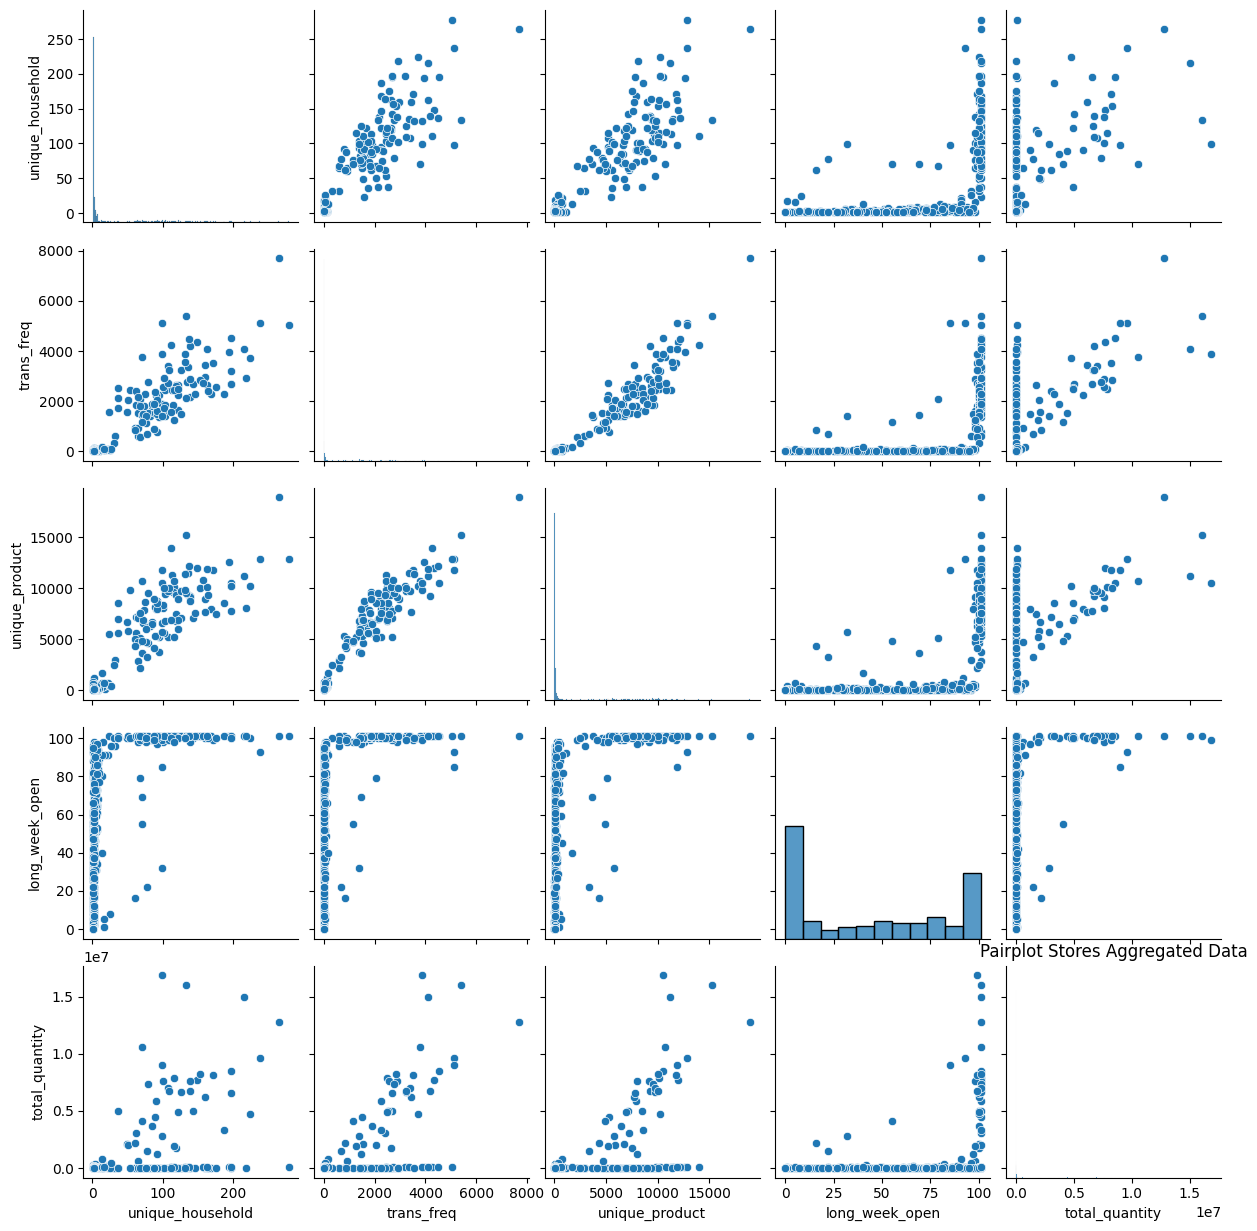

In [88]:
# Store segmentation based on number of unique household that has bought 
stores = df.groupby(['STORE_ID'],as_index=False).agg({'household_key':'nunique','BASKET_ID':'nunique','PRODUCT_ID':'nunique','WEEK_NO':np.ptp,'QUANTITY':'sum'})

stores.columns = ['STORE_ID', 'unique_household', 'trans_freq','unique_product','long_week_open','total_quantity']

# Pairplot data aggregation
sns.pairplot(data=stores.drop('STORE_ID', axis=1))
plt.title('Pairplot Stores Aggregated Data')



Text(0.5, 1.0, 'Elbow Method - Stores Cluster')

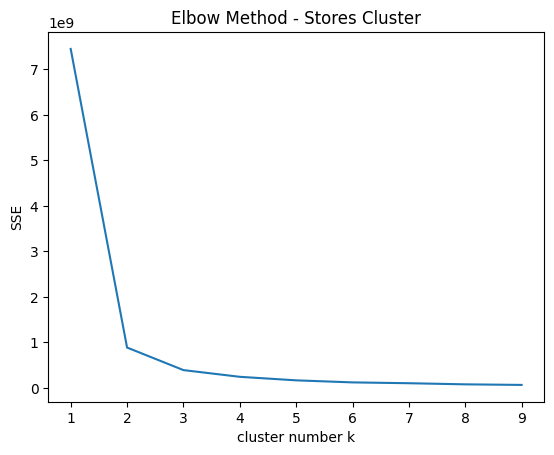

In [89]:
# Elbow Method to decide how many cluster best use based on SSE

SSE = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, random_state=42, n_init="auto").fit(stores.drop(['STORE_ID','total_quantity'],axis=1))
    stores["elbow"] = kmeans.labels_
    SSE[k] = kmeans.inertia_ 
    
# Plot the result
sp = sns.lineplot(data=SSE)
sp.set(xlabel='cluster number k', ylabel='SSE')
plt.title('Elbow Method - Stores Cluster')

In the Elbow Method plot above, selecting k=3 clusters is preferable, as the SSE significantly decreases up to k=3 and then shows a diminishing return, indicating the 'elbow' point.

Text(0.5, 1.0, 'Store Cluster')

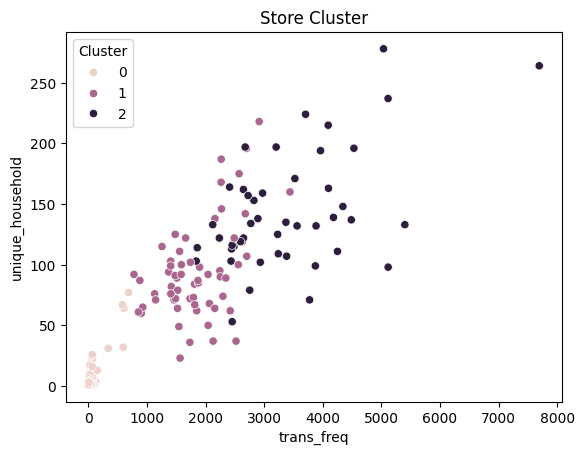

In [90]:
# KMeans Result segmenting store

kmeans = KMeans(n_clusters=3)
stores['Cluster'] = kmeans.fit_predict(stores.drop(['STORE_ID','total_quantity'],axis=1))
sns.scatterplot(data=stores, x='trans_freq', y='unique_household', hue='Cluster')
plt.title('Store Cluster')

From the cluster we can classify into three big group:
- cluster 0 : low transaction and low number of customers
- cluster 2 : medium traffic transaction and medium number of customers
- cluster 1 : high traffic transaction and high traffic of customers

In [91]:
# Merging the stores and transaction data
df = pd.merge(df, stores[['STORE_ID','Cluster']], how='left', on='STORE_ID')

# Sort data based on time purchase to preserve the timeliness

df.sort_values(['DAY','TRANS_TIME'], inplace=True)

# Show Example of Data
df.head()

household_key    BASKET_ID  DAY PRODUCT_ID  QUANTITY  SALES_VALUE STORE_ID  \
0          1172  26985025264    1     877180         1         2.29      396   
1          1172  26985025264    1     878664         1         2.00      396   
2          1172  26985025264    1     930917         2         2.00      396   
3          1172  26985025264    1     940796         1         3.59      396   
4          1172  26985025264    1     981760         1         0.79      396   

   RETAIL_DISC  TRANS_TIME  WEEK_NO  ...  DEPARTMENT     BRAND  \
0         0.00         946        1  ...     DRUG GM  National   
1        -0.99         946        1  ...     DRUG GM  National   
2        -0.78         946        1  ...     GROCERY  National   
3         0.00         946        1  ...     DRUG GM  National   
4        -0.60         946        1  ...     GROCERY   Private   

          COMMODITY_DESC SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  \
0    SOAP - LIQUID & BAR          BODY WASH                        
1  ORAL HYGIENE PRODUCTS         TOOTHPASTE                 6 OZ   
2    MEAT - SHELF STABLE      PASTA: CANNED                15 OZ   
3     HAIR CARE PRODUCTS            SHAMPOO                15 OZ   
4                   EGGS     EGGS - X-LARGE                 1 DZ   

  REAL_SALES_VALUE PRODUCT_PRICE COUPON_FLAG INTERACTION Cluster  
0             2.29          2.29           0          00       2  
1             2.99          2.99           0          00       2  
2             2.78          1.39           0          00       2  
3             3.59          3.59           0          00       2  
4             1.39          1.39           0          00       2  

[5 rows x 25 columns]

<a id="ft"></a>
<h3>Variable Transformation</h3>

We will transform categorical variables into numerical variables and use data standardization 

For now we will keep all of this information for EDA purposes



In [92]:
# Dummy Encode Display and Mailer
df = pd.concat([df,pd.get_dummies(df['display'], prefix='display', drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df['mailer'], prefix='mailer', drop_first=True)],axis=1)


# Encoding Data
categorical_cols = ['DEPARTMENT','COMMODITY_DESC','SUB_COMMODITY_DESC','BRAND','INTERACTION']
categorical_cols_new = [col+'_en' for col in categorical_cols]
encoder = OrdinalEncoder()
df[categorical_cols_new] = encoder.fit_transform(df[categorical_cols])
df.head(5)

household_key    BASKET_ID  DAY PRODUCT_ID  QUANTITY  SALES_VALUE STORE_ID  \
0          1172  26985025264    1     877180         1         2.29      396   
1          1172  26985025264    1     878664         1         2.00      396   
2          1172  26985025264    1     930917         2         2.00      396   
3          1172  26985025264    1     940796         1         3.59      396   
4          1172  26985025264    1     981760         1         0.79      396   

   RETAIL_DISC  TRANS_TIME  WEEK_NO  ...  mailer_H  mailer_J mailer_L  \
0         0.00         946        1  ...     False     False    False   
1        -0.99         946        1  ...     False     False    False   
2        -0.78         946        1  ...     False     False    False   
3         0.00         946        1  ...     False     False    False   
4        -0.60         946        1  ...     False     False    False   

  mailer_X mailer_Z DEPARTMENT_en COMMODITY_DESC_en SUB_COMMODITY_DESC_en  \
0    False    False           9.0             271.0                 233.0   
1    False    False           9.0             212.0                2222.0   
2    False    False          16.0             189.0                1575.0   
3    False    False           9.0             152.0                1977.0   
4    False    False          16.0             102.0                 692.0   

  BRAND_en INTERACTION_en  
0      0.0            0.0  
1      0.0            0.0  
2      0.0            0.0  
3      0.0            0.0  
4      1.0            0.0  

[5 rows x 48 columns]

In [93]:
# Standard Scaler Data

# Initiate Standard Scaler
scaler = StandardScaler()

# Columns that will be scaled
col_scaler = ['QUANTITY','DEPARTMENT_en','COMMODITY_DESC_en','SUB_COMMODITY_DESC_en','INTERACTION_en','PRODUCT_PRICE','DAY']
col_scaler_new = [col+'_std' for col in col_scaler]
df[col_scaler_new] = scaler.fit_transform(df[col_scaler])

# The rest of the columns will not be scaled due to uniform value


In [94]:
# Printing columns after doing transformation and standardisation
df.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO',
       'COUPON_DISC', 'COUPON_MATCH_DISC', 'display', 'mailer', 'MANUFACTURER',
       'DEPARTMENT', 'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC',
       'CURR_SIZE_OF_PRODUCT', 'REAL_SALES_VALUE', 'PRODUCT_PRICE',
       'COUPON_FLAG', 'INTERACTION', 'Cluster', 'display_1', 'display_2',
       'display_3', 'display_4', 'display_5', 'display_6', 'display_7',
       'display_9', 'display_A', 'mailer_A', 'mailer_C', 'mailer_D',
       'mailer_F', 'mailer_H', 'mailer_J', 'mailer_L', 'mailer_X', 'mailer_Z',
       'DEPARTMENT_en', 'COMMODITY_DESC_en', 'SUB_COMMODITY_DESC_en',
       'BRAND_en', 'INTERACTION_en', 'QUANTITY_std', 'DEPARTMENT_en_std',
       'COMMODITY_DESC_en_std', 'SUB_COMMODITY_DESC_en_std',
       'INTERACTION_en_std', 'PRODUCT_PRICE_std', 'DAY_std'],
      dtype='object')

<a id="eda"></a>
<h2>Exploratory Data Analysis (EDA)</h2>

- [EDA focusing on product data](#eda_pr)
- [EDA focusing on causal data](#eda_cau)
- [EDA focusing on combined dataset (transaction, product, and causal data)](#eda_cd)
- [Data Distribution for the Predictors and Target](#eda_dd)
- [Correlation Analysis](#eda_corr)

<a id="eda_pr"></a>
<h3>EDA focusing on product data</h3>

Business Question:
- Are all products in the store being sold?
- If not, which products have not appeared in any transactions or remain unsold?

In [95]:
# Are all products in the store being sold?

#percentage of product sold
print('Percentage Products Sold (%)')
print(transaction_data['PRODUCT_ID'].nunique()/product['PRODUCT_ID'].nunique()*100)
print('Not Sold Products (%)')
print(100-transaction_data['PRODUCT_ID'].nunique()/product['PRODUCT_ID'].nunique()*100)


Percentage Products Sold (%)
99.98484077398678
Not Sold Products (%)
0.015159226013224725


In [96]:
#List of Products Not Sold
not_sold = product[product['PRODUCT_ID'].isin(set(product['PRODUCT_ID'])-set(transaction_data['PRODUCT_ID']))]
print(f'There are {len(not_sold)} of products')
not_sold

There are 14 of products


PRODUCT_ID  MANUFACTURER DEPARTMENT     BRAND  \
937         56663            69    GROCERY   Private   
3761       424426            69  NUTRITION   Private   
7538       833727          2393  COSMETICS  National   
13236      883999          5583  COSMETICS  National   
14038      891602          5029    DRUG GM  National   
25547      993259           638    GROCERY  National   
39577     1118507          4978    DRUG GM  National   
49472     2068363             2    PRODUCE  National   
61099     7441392           958  COSMETICS  National   
63391     8180896           603    DRUG GM  National   
70966     9887432           856    DRUG GM  National   
77133    12487909          1628    DRUG GM  National   
78081    12605548          1937    DRUG GM  National   
89619    15972075           471  COSMETICS  National   

                 COMMODITY_DESC              SUB_COMMODITY_DESC  \
937               FRZN POTATOES               FRZN FRENCH FRIES   
3761                      WATER                    SPRING WATER   
7538                 FRAGRANCES             DESIGNER FRAGRANCES   
13236                FRAGRANCES             DESIGNER FRAGRANCES   
14038     ORAL HYGIENE PRODUCTS               DENTURE CLEANSERS   
25547       FROZEN PIE/DESSERTS  FROZEN CAKES/ALL TYPES INCLUDI   
39577            INFANT FORMULA        INFANT FORMULA MILK BASE   
49472                    SQUASH                 SQUASH ZUCCHINI   
61099      MAKEUP AND TREATMENT                      MAYBELLINE   
63391                  VITAMINS            VITAMIN - INDIVIDUAL   
70966      DIETARY AID PRODUCTS     DIET CNTRL BARS NUTRITIONAL   
77133                 HALLOWEEN                LOREAL COSMETICS   
78081  PERSONAL CARE APPLIANCES     PERSNL APPL: FT BTH/MASSGRS   
89619                FRAGRANCES                PARFUMS DE COUER   

      CURR_SIZE_OF_PRODUCT  
937                  32 OZ  
3761               16.9 OZ  
7538                        
13236                       
14038                       
25547             10.75 OZ  
39577            26 REC OZ  
49472                18 LB  
61099                       
63391                       
70966                 1 CT  
77133                       
78081                       
89619

There are 14 products that are not reflected in any transactions. This presents an opportunity to boost their sales by identifying potential reasons for their underperformance and addressing those issues effectively.

<a id="eda_cau"></a>
<h3>EDA focusing on Causal Data</h3>

Causal Data contains >3mio of data.
Here we will explore the causal data strategy that was impelmented

Business Question:
- Is there any pattern within the causal data?
- Does all store apply the same strategy?
- How many causal data convereted into sales?
- for the top three department, how is the display, mailer and interaction differs from one department to another? which one has the highest success rate?



Is there any pattern within the causal data?

In [97]:
# Is there any pattern within the causal data?

focus_display = causal_data[causal_data['mailer']=='0']
focus_mailer = causal_data[causal_data['display']=='0']
print('Causal Experiment - Focus on Display')
print(len(focus_display), len(focus_display)/len(causal_data)*100)
print('Causal Experiment - Focus on Mailer')
print(len(focus_mailer), len(focus_mailer)/len(causal_data)*100)
print('Causal Experiment - Focus on Interaction')
print(len(causal_data)-len(focus_display)-len(focus_mailer), (len(causal_data)-len(focus_display)-len(focus_mailer))/len(causal_data)*100)

Causal Experiment - Focus on Display
11534183 31.354370421081374
Causal Experiment - Focus on Mailer
21038745 57.19144597624934
Causal Experiment - Focus on Interaction
4213596 11.454183602669282


In [98]:
# Segmenting data based on strategy, from mailer, display and interaction from the causal data
causal_mail = causal_data[(causal_data['mailer']!='0') & (causal_data['display']=='0')]
causal_display = causal_data[(causal_data['mailer']=='0') & (causal_data['display']!='0')]
causal_interaction = causal_data[(causal_data['mailer']!='0') & (causal_data['display']!='0')]
causal_interaction['INTERACTION'] = causal_interaction['display']+causal_interaction['mailer']

/var/folders/9f/klpz4yzx3hq9bcs22_drg0740000gn/T/ipykernel_45673/1078360225.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causal_interaction['INTERACTION'] = causal_interaction['display']+causal_interaction['mailer']


In [99]:
# Define distinct color palettes for each strategy

# Define the unique display types and their colors
display_types = causal_display['display'].unique()  # Extract unique display types
display_colors_palette = sns.color_palette('viridis', n_colors=len(display_types))  # Generate colors
# Create a dictionary to map display types to specific colors
display_color_map = dict(zip(display_types, display_colors_palette))

# Define unique mailer type and their color
mailer_types = causal_mail['mailer'].unique()  # Extract unique display types
mailer_colors_palette = sns.color_palette('coolwarm', n_colors=len(mailer_types))  # Generate colors
# Create a dictionary to map display types to specific colors
mailer_color_map = dict(zip(mailer_types, mailer_colors_palette))

# Define unique mailer type and their color
interaction_types = causal_interaction['INTERACTION'].unique()  # Extract unique display types
interaction_colors_palette = sns.color_palette('tab10', n_colors=len(interaction_types))  # Generate colors
# Create a dictionary to map display types to specific colors
interaction_color_map = dict(zip(interaction_types, interaction_colors_palette))

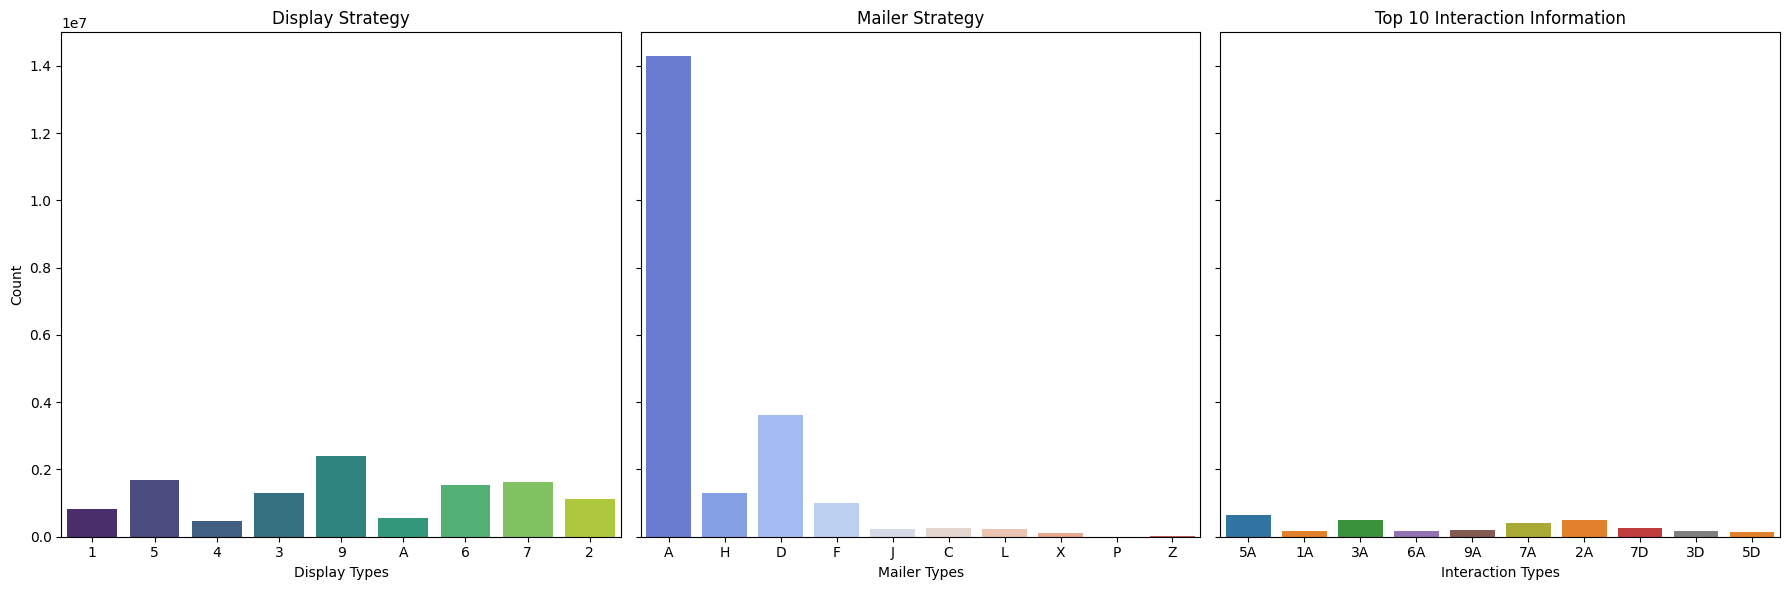

In [100]:
# For each strategy, does each type have the same number?

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Share y-axis for better comparison

# 1. Display Information
sns.countplot(data=causal_display, x='display', hue='display', ax=axes[0], palette=display_color_map)
axes[0].set_title('Display Strategy')
axes[0].set_xlabel('Display Types')
axes[0].set_ylabel('Count')

# 2. Mailer Information
sns.countplot(data=causal_mail, x='mailer', hue='mailer', ax=axes[1], palette=mailer_color_map)
axes[1].set_title('Mailer Strategy')
axes[1].set_xlabel('Mailer Types')
axes[1].set_ylabel('')

# 3. Interaction Information
# Get the top 10 most common interaction types
top_10_interactions = (
    causal_interaction['INTERACTION']
    .value_counts()
    .head(10)
    .index
)

# Filter the data to include only the top 10 interaction types
filtered_causal_interaction = causal_interaction[causal_interaction['INTERACTION'].isin(top_10_interactions)]

# Create the countplot for top 10 interaction types
sns.countplot(
    data=filtered_causal_interaction, 
    x='INTERACTION', 
    hue='INTERACTION', 
    ax=axes[2], 
    palette=interaction_color_map
)
axes[2].set_title('Top 10 Interaction Information')
axes[2].set_xlabel('Interaction Types')
axes[2].set_ylabel('')


# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


Does the store apply the same display and mailer strategy?

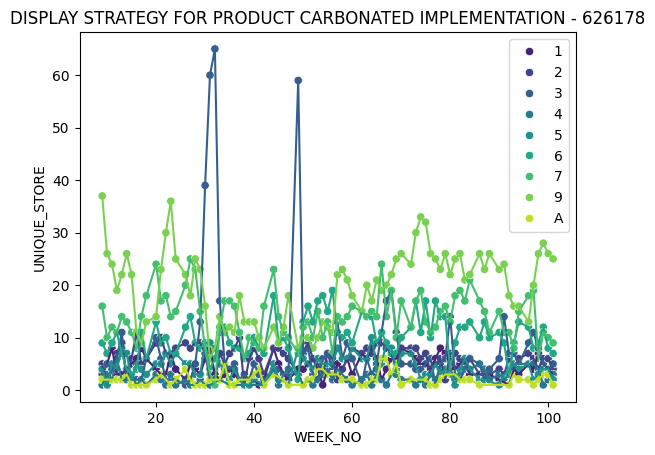

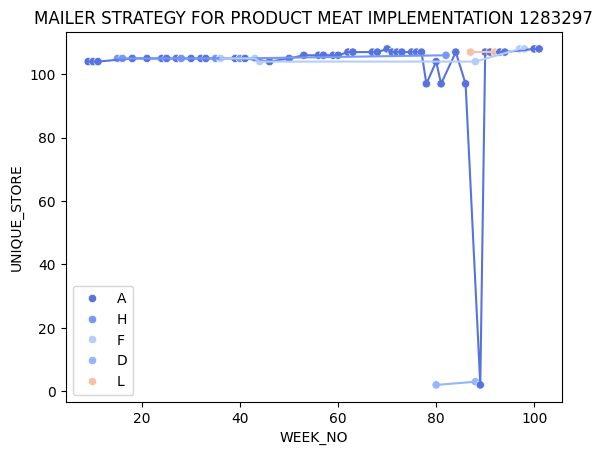

In [101]:
# Does the store apply the same display and mailer strategy?

# We will choose the mode of the product in causal data and plot the number of stores that apply the same strategy

# Merge with product data
causal_display = pd.merge(causal_display, product, on='PRODUCT_ID', how='left')
causal_mail = pd.merge(causal_mail, product, on='PRODUCT_ID', how='left')
causal_interaction = pd.merge(causal_interaction, product, on='PRODUCT_ID', how='left')

#display strategy aggregate to find the number of store that use the same display strategy
display_strategy = causal_display.groupby(['PRODUCT_ID','WEEK_NO','display'],as_index=False).agg({'STORE_ID':'nunique',
                                                                                                 'DEPARTMENT':'first',
                                                                                                 'COMMODITY_DESC':'first',
                                                                                                 'SUB_COMMODITY_DESC':'first'})
display_strategy.columns = ['PRODUCT_ID', 'WEEK_NO','DISPLAY','UNIQUE_STORE','DEPARTMENT','COMMODITY_DESC','SUB_COMMODITY_DESC']



# after inspecting, product_id 626178 is the most frequent product that was recorded, therefore we will look at the display strategy along the week

sns.lineplot(data=display_strategy[display_strategy['PRODUCT_ID']==626178], x='WEEK_NO', y='UNIQUE_STORE', hue='DISPLAY',legend=False,palette=display_colors_palette)
sns.scatterplot(data=display_strategy[display_strategy['PRODUCT_ID']==626178], x='WEEK_NO', y='UNIQUE_STORE', hue='DISPLAY',palette=display_colors_palette)
plt.legend()
plt.title('DISPLAY STRATEGY FOR PRODUCT CARBONATED IMPLEMENTATION - 626178')
plt.show()


# mailer strategy
mailer_strategy = causal_mail.groupby(['PRODUCT_ID','WEEK_NO','mailer'],as_index=False).agg({'STORE_ID':'nunique',
                                                                                                 'DEPARTMENT':'first',
                                                                                                 'COMMODITY_DESC':'first',
                                                                                                 'SUB_COMMODITY_DESC':'first'})
mailer_strategy.columns = ['PRODUCT_ID', 'WEEK_NO','MAILER','UNIQUE_STORE','DEPARTMENT','COMMODITY_DESC','SUB_COMMODITY_DESC']

sns.lineplot(data=mailer_strategy[mailer_strategy['PRODUCT_ID']==1283297], x='WEEK_NO', y='UNIQUE_STORE', hue='MAILER',legend=False,palette=mailer_color_map)
sns.scatterplot(data=mailer_strategy[mailer_strategy['PRODUCT_ID']==1283297], x='WEEK_NO', y='UNIQUE_STORE', hue='MAILER',palette=mailer_color_map)
plt.legend()
plt.title('MAILER STRATEGY FOR PRODUCT MEAT IMPLEMENTATION 1283297')
plt.show()

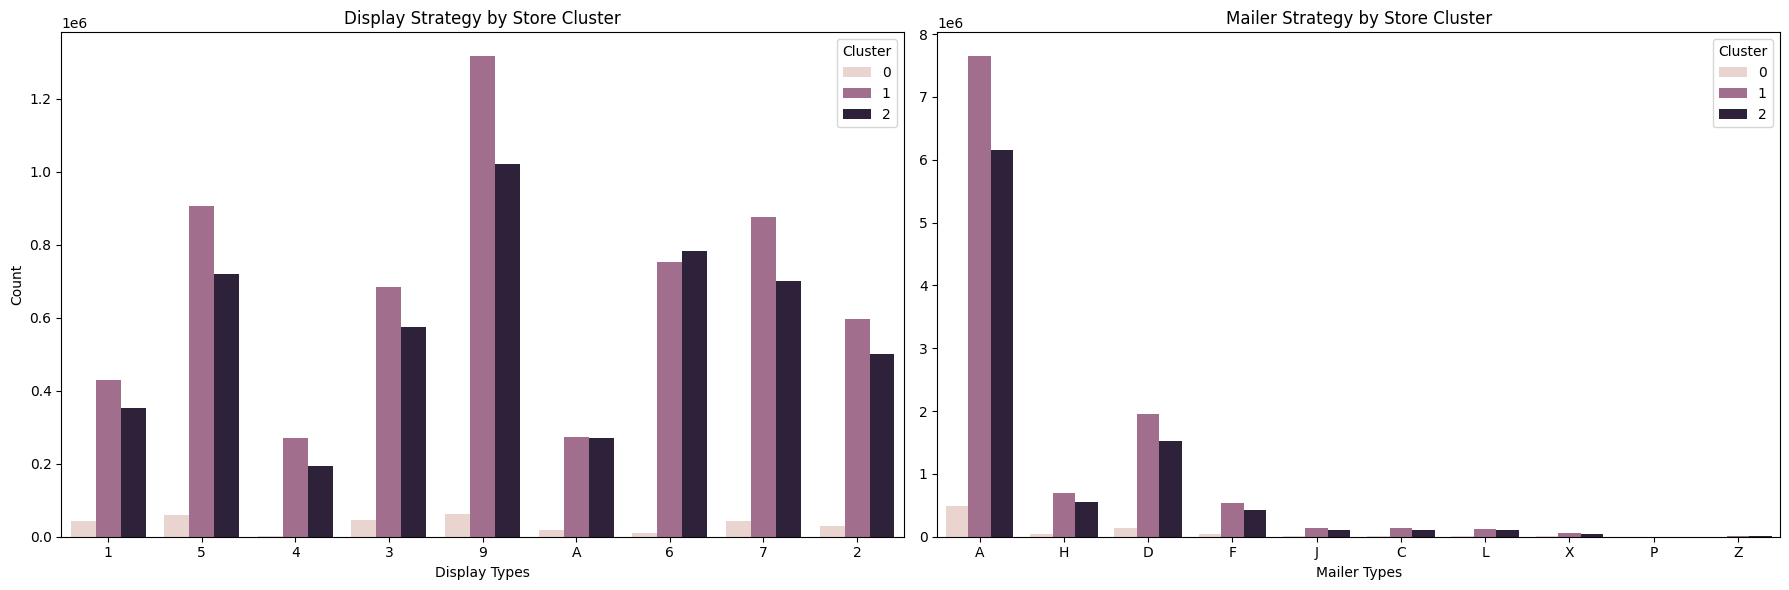

In [102]:
# Does the company implement display and mailer strategies consistently across all store clusters, 
# or are there specific clusters where these strategies are emphasized?

# Merge with the store information
causal_display = pd.merge(causal_display, stores[['STORE_ID','Cluster']], on='STORE_ID', how='left')
causal_mail = pd.merge(causal_mail, stores[['STORE_ID','Cluster']], on='STORE_ID', how='left')
causal_interaction = pd.merge(causal_interaction, stores[['STORE_ID','Cluster']], on='STORE_ID', how='left')

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)


# 1. Display Experimentation based on store type cluster
sns.countplot(data=causal_display, x='display', hue='Cluster', ax=axes[0])
axes[0].set_title('Display Strategy by Store Cluster')
axes[0].set_xlabel('Display Types')
axes[0].set_ylabel('Count')
axes[0].legend(title='Cluster')

# 2. Mailer Experimentation based on store type cluster
sns.countplot(data=causal_mail, x='mailer', hue='Cluster', ax=axes[1])
axes[1].set_title('Mailer Strategy by Store Cluster')
axes[1].set_xlabel('Mailer Types')
axes[1].set_ylabel('')  # No y-label for the second plot to avoid redundancy
axes[1].legend(title='Cluster')

# Adjust layout
plt.tight_layout()
plt.show()


How many causal data convereted into sales?

[1.3745781889556625, 1.2924885967215882, 2.9235360960092045]


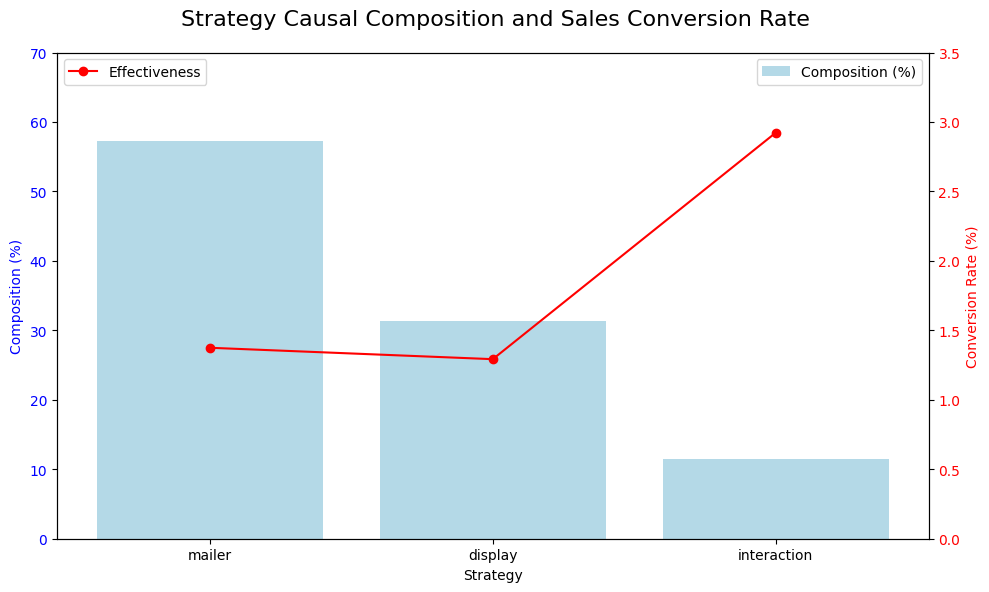

In [103]:
# Conversion from starategy to sales


# Segmenting data based on stratey, from mailer, display, and interaction from the trasanction data
df_nona = df[df['INTERACTION']!='00']
sales_mail = df_nona[(df_nona['mailer']!='0') & (df_nona['display']=='0')]
sales_display = df_nona[(df_nona['mailer']=='0') & (df_nona['display']!='0')]
sales_interaction = df_nona[(df_nona['mailer']!='0') & (df_nona['display']!='0')]

# Initial strategy Composition from Causal Data
strategies = ['mailer','display','interaction']

# Calculating by # of rows in each strategy/ # of rows in overall causal data
composition = [len(causal_mail)/len(causal_data)*100, len(causal_display)/len(causal_data)*100, len(causal_interaction)/len(causal_data)*100]

# Conversion of each strategy to transaction based on number of data
effectiveness = [len(sales_mail)/len(causal_mail)*100, len(sales_display)/len(causal_display)*100, len(sales_interaction)/len(causal_interaction)*100]

print(effectiveness)

# Create a figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for composition
sns.barplot(x=strategies, y=composition, ax=ax1, color='skyblue', alpha=0.7, label='Composition (%)')
ax1.set_ylabel('Composition (%)', color='blue')
ax1.set_ylim(0, 70)  # Adjust as needed
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Strategy')

# Line plot for effectiveness (dual axis)
ax2 = ax1.twinx()
ax2.plot(strategies, effectiveness, color='red', marker='o', label='Effectiveness')
ax2.set_ylabel('Conversion Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 3.5)  # Adjust as needed

# Title and legend
fig.suptitle('Strategy Causal Composition and Sales Conversion Rate', fontsize=16)
ax2.legend(loc='upper left')
plt.tight_layout()
plt.show()

for the top three department, how is the display, mailer and interaction differs from one department to another? which one has the highest success rate?

In [104]:
# choose example of the top 3 department
top3_dept = df_nona[['DEPARTMENT','display','mailer','INTERACTION']]['DEPARTMENT'].value_counts().head(3).index

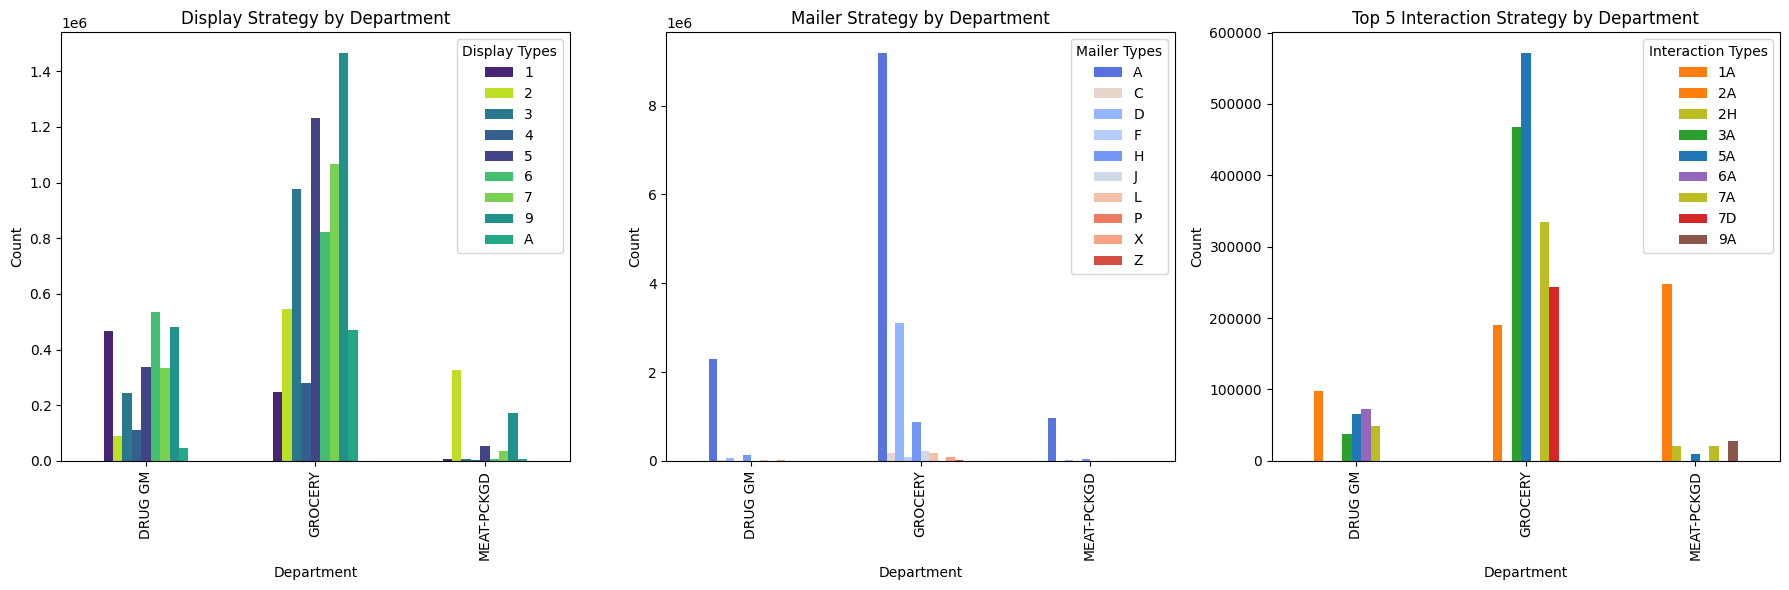

In [105]:
# Sales Strategy based on the top 3 department
# Initialize lists for plotting
display_details = []
mailer_details = []
interaction_details = []

# Prepare detailed data for each department in sales data
for dep in top3_dept:
    # Filter data for the department
    display_dept = causal_display[causal_display['DEPARTMENT'] == dep]
    mailer_dept = causal_mail[causal_mail['DEPARTMENT'] == dep]
    inter_dept = causal_interaction[causal_interaction['DEPARTMENT'] == dep]

    # Group and count for details
    display_group = display_dept.groupby('display').size().reset_index(name='count')
    display_group['DEPARTMENT'] = dep
    display_details.append(display_group)

    mailer_group = mailer_dept.groupby('mailer').size().reset_index(name='count')
    mailer_group['DEPARTMENT'] = dep
    mailer_details.append(mailer_group)

    interaction_group = inter_dept.groupby('INTERACTION').size().reset_index(name='count')
    interaction_group['DEPARTMENT'] = dep
    interaction_group = interaction_group.nlargest(5, 'count')  # Only top 5
    interaction_details.append(interaction_group)

# Combine all departments' data
display_df = pd.concat(display_details, ignore_index=True)
mailer_df = pd.concat(mailer_details, ignore_index=True)
interaction_df = pd.concat(interaction_details, ignore_index=True)

# Pivot data for stacked bar charts
display_stacked_cau = display_df.pivot(index='DEPARTMENT', columns='display', values='count').fillna(0)
mailer_stacked_cau = mailer_df.pivot(index='DEPARTMENT', columns='mailer', values='count').fillna(0)
interaction_stacked_cau = interaction_df.pivot(index='DEPARTMENT', columns='INTERACTION', values='count').fillna(0)


# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# 1. Stacked bar chart for display types
display_stacked_cau.plot(kind='bar', stacked=False, ax=axes[0], color=[display_color_map[col] for col in display_stacked_cau.columns])
axes[0].set_title('Display Strategy by Department')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Department')
axes[0].legend(title='Display Types')

# 2. Stacked bar chart for mailer types
mailer_stacked_cau.plot(kind='bar', stacked=False, ax=axes[1], color=[mailer_color_map[col] for col in mailer_stacked_cau.columns])
axes[1].set_title('Mailer Strategy by Department')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Department')
axes[1].legend(title='Mailer Types')

# 3. Stacked bar chart for interaction types
interaction_stacked_cau.plot(kind='bar', stacked=False, ax=axes[2], color=[interaction_color_map[col] for col in interaction_stacked_cau.columns])
axes[2].set_title('Top 5 Interaction Strategy by Department')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Department')
axes[2].legend(title='Interaction Types')

# Adjust layout
plt.tight_layout()
plt.show()

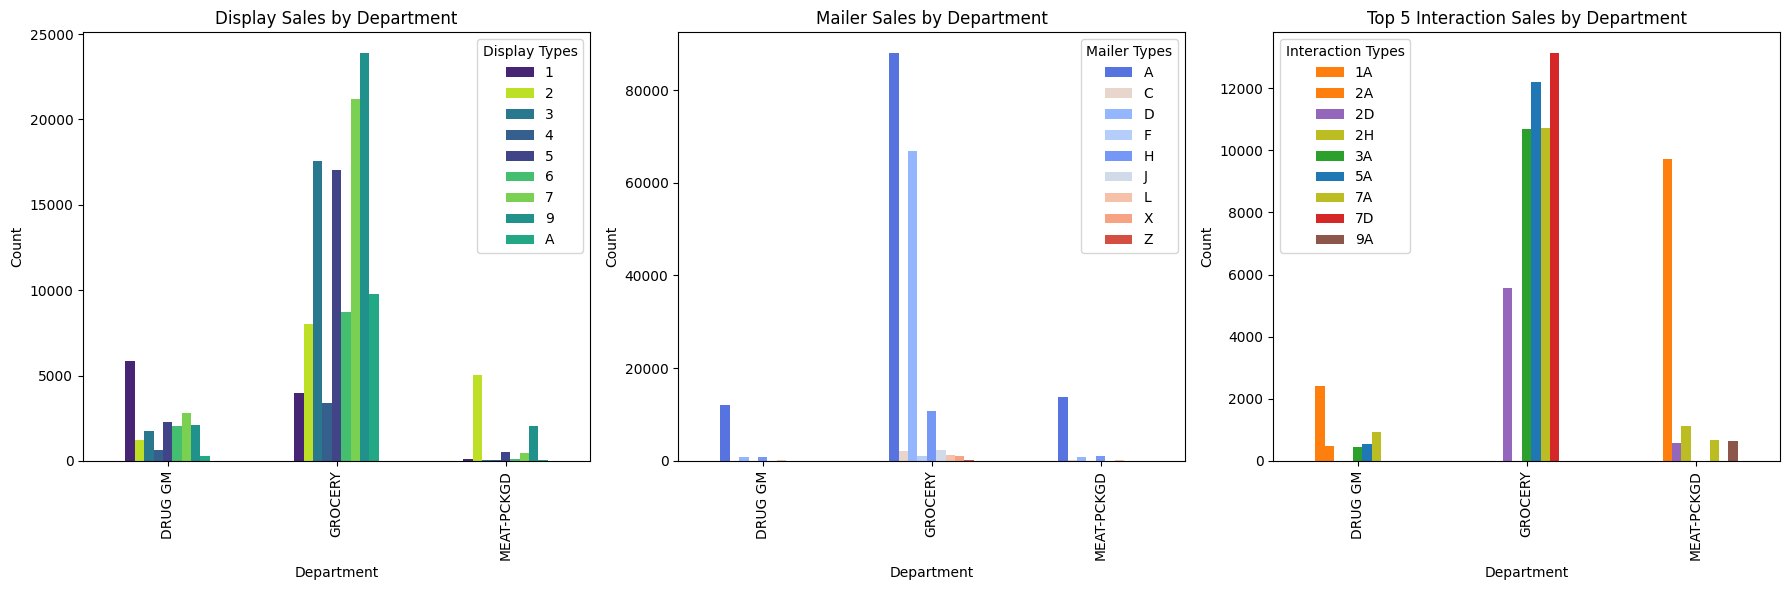

In [106]:
# Initialize lists for plotting
display_details = []
mailer_details = []
interaction_details = []

# Prepare detailed data for each department in sales data
for dep in top3_dept:
    # Filter data for the department
    display_dept = sales_display[sales_display['DEPARTMENT'] == dep]
    mailer_dept = sales_mail[sales_mail['DEPARTMENT'] == dep]
    inter_dept = sales_interaction[sales_interaction['DEPARTMENT'] == dep]

    # Group and count for details
    display_group = display_dept.groupby('display').size().reset_index(name='count')
    display_group['DEPARTMENT'] = dep
    display_details.append(display_group)

    mailer_group = mailer_dept.groupby('mailer').size().reset_index(name='count')
    mailer_group['DEPARTMENT'] = dep
    mailer_details.append(mailer_group)

    interaction_group = inter_dept.groupby('INTERACTION').size().reset_index(name='count')
    interaction_group['DEPARTMENT'] = dep
    interaction_group = interaction_group.nlargest(5, 'count')  # Only top 5
    interaction_details.append(interaction_group)

# Combine all departments' data
display_df = pd.concat(display_details, ignore_index=True)
mailer_df = pd.concat(mailer_details, ignore_index=True)
interaction_df = pd.concat(interaction_details, ignore_index=True)

# Pivot data for stacked bar charts
display_stacked = display_df.pivot(index='DEPARTMENT', columns='display', values='count').fillna(0)
mailer_stacked = mailer_df.pivot(index='DEPARTMENT', columns='mailer', values='count').fillna(0)
interaction_stacked = interaction_df.pivot(index='DEPARTMENT', columns='INTERACTION', values='count').fillna(0)


# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Stacked bar chart for display types
display_stacked.plot(kind='bar', stacked=False, ax=axes[0], color=[display_color_map[col] for col in display_stacked.columns])
axes[0].set_title('Display Sales by Department')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Department')
axes[0].legend(title='Display Types')

# Stacked bar chart for mailer types
mailer_stacked.plot(kind='bar', stacked=False, ax=axes[1], color=[mailer_color_map[col] for col in mailer_stacked.columns])
axes[1].set_title('Mailer Sales by Department')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Department')
axes[1].legend(title='Mailer Types')

# Stacked bar chart for interaction types
interaction_stacked.plot(kind='bar', stacked=False, ax=axes[2], color=[interaction_color_map[col] for col in interaction_stacked.columns])
axes[2].set_title('Top 5 Interaction Sales by Department')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Department')
axes[2].legend(title='Interaction Types')

# Adjust layout
plt.tight_layout()
plt.show()

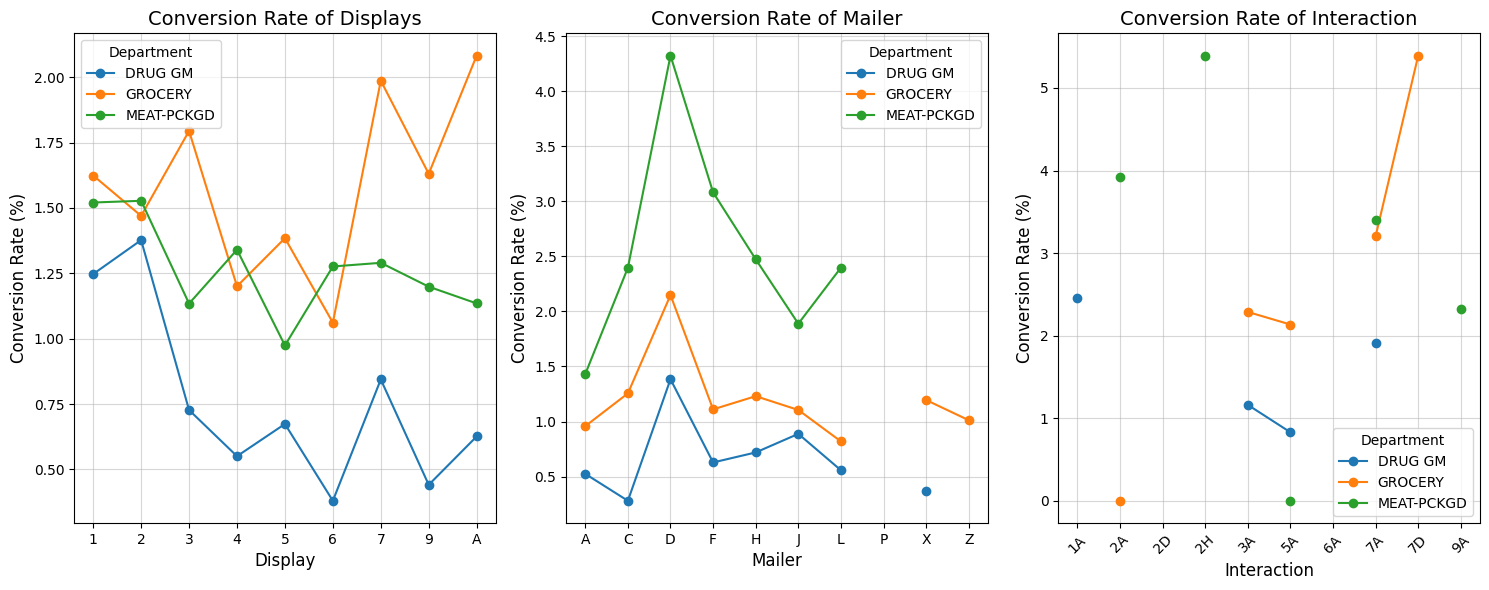

In [107]:
# Calculate effectiveness (Sales per Display Unit)
display_effectiveness = display_stacked / display_stacked_cau*100
mailer_effectiveness = mailer_stacked / mailer_stacked_cau*100
interaction_effectiveness = interaction_stacked / interaction_stacked_cau*100

# Plotting the effectiveness
fig, ax = plt.subplots(1,3, figsize=(15, 6))

departments = ["DRUG GM", "GROCERY", "MEAT-PCKGD"]



for department in departments:
    ax[0].plot(display_effectiveness.columns, display_effectiveness.loc[department], marker='o', label=department)
    ax[1].plot(mailer_effectiveness.columns, mailer_effectiveness.loc[department], marker='o', label=department)
    ax[2].plot(interaction_effectiveness.columns, interaction_effectiveness.loc[department], marker='o', label=department)

# Formatting the plot
ax[0].set_title("Conversion Rate of Displays", fontsize=14)
ax[0].set_xlabel("Display", fontsize=12)
ax[0].set_ylabel("Conversion Rate (%)", fontsize=12)
ax[0].legend(title="Department")
ax[0].grid(alpha=0.5)

ax[1].set_title("Conversion Rate of Mailer", fontsize=14)
ax[1].set_xlabel("Mailer", fontsize=12)
ax[1].set_ylabel("Conversion Rate (%)", fontsize=12)
ax[1].legend(title="Department")
ax[1].grid(alpha=0.5)

ax[2].set_title("Conversion Rate of Interaction", fontsize=14)
ax[2].set_xlabel("Interaction", fontsize=12)
ax[2].set_ylabel("Conversion Rate (%)", fontsize=12)
ax[2].legend(title="Department")
ax[2].grid(alpha=0.5)

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

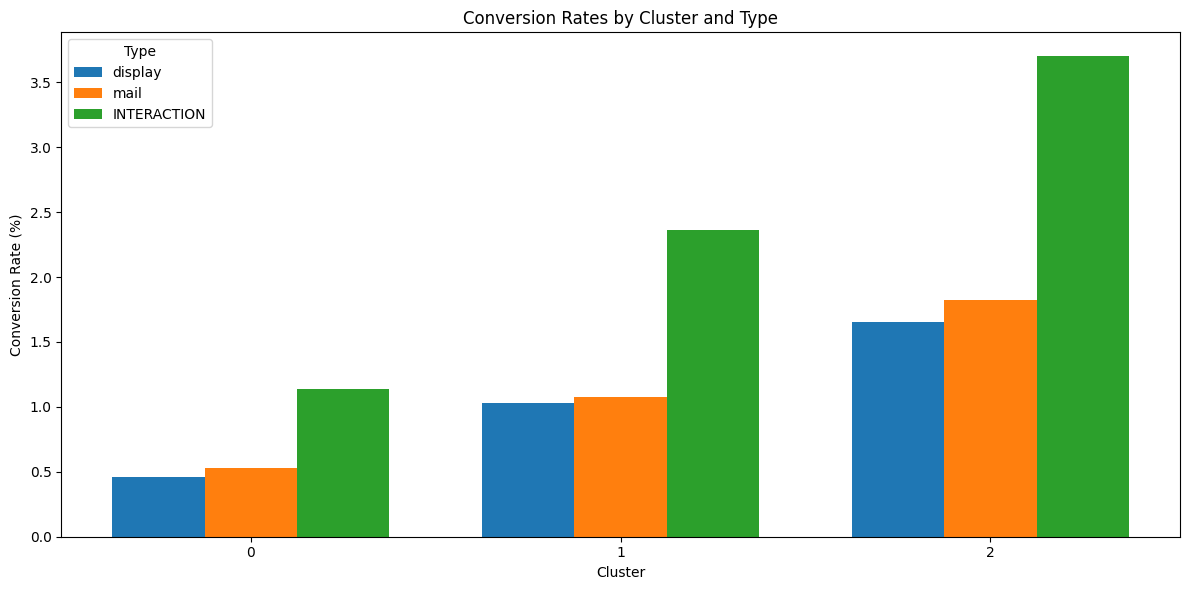

In [108]:
# How does to conversation rate for each strategy for each type of cluster?
def calculate_conversion_rate(sales_data, cau_data, data_type):
    # Count transactions by cluster
    transaction_counts = sales_data.groupby('Cluster').size().reset_index(name='Transactions')

    # Count strategies by cluster
    strategy_counts = cau_data.groupby('Cluster').size().reset_index(name='Strategies')

    # Merge the data
    merged_data = pd.merge(transaction_counts, strategy_counts, on='Cluster', how='outer').fillna(0)

    # Calculate conversion rate
    merged_data['Conversion Rate'] = merged_data['Transactions'] / merged_data['Strategies']*100
    merged_data['Conversion Rate'] = merged_data['Conversion Rate'].replace([float('inf'), None], 0)  # Handle division by zero

    # Add a column for data type
    merged_data['Type'] = data_type

    return merged_data

# Calculate conversion rates for each dataset
display_data = calculate_conversion_rate(sales_display, causal_display, 'display')
mail_data = calculate_conversion_rate(sales_mail, causal_mail, 'mail')
interaction_data = calculate_conversion_rate(sales_interaction, causal_interaction, 'INTERACTION')

# Combine all results into one DataFrame
all_data = pd.concat([display_data, mail_data, interaction_data], ignore_index=True)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Define the width of each bar
bar_width = 0.25

# Get unique clusters and types
clusters = sorted(all_data['Cluster'].unique())
types = all_data['Type'].unique()

# Generate positions for the bars
x = np.arange(len(clusters))  # Base positions for the clusters

# Loop through each type to create side-by-side bars
for i, data_type in enumerate(types):
    subset = all_data[all_data['Type'] == data_type]
    
    # Adjust bar positions using the index `i` and bar width
    bar_positions = x + i * bar_width
    
    ax.bar(bar_positions, subset['Conversion Rate'], width=bar_width, label=data_type)

# Customize the plot
ax.set_title('Conversion Rates by Cluster and Type')
ax.set_xlabel('Cluster')
ax.set_ylabel('Conversion Rate (%)')
ax.set_xticks(x + (bar_width * (len(types) - 1) / 2))  # Center the x-ticks under grouped bars
ax.set_xticklabels(clusters)  # Label x-ticks with cluster names
ax.legend(title='Type')
plt.tight_layout()

plt.show()


#top department in each cluster


In [109]:
#top department in each cluster and how it differs in each department

# top3 dept for each cluster
c0 = df_nona[df_nona['Cluster']==0]
c1 = df_nona[df_nona['Cluster']==1]
c2 = df_nona[df_nona['Cluster']==2]

print('Top 3 Department in Store Cluster 0: ', c0['DEPARTMENT'].value_counts().head(3).index.to_list())
print('Top 3 Department in Store Cluster 1: ', c1['DEPARTMENT'].value_counts().head(3).index.to_list())
print('Top 3 Department in Store Cluster 2: ', c2['DEPARTMENT'].value_counts().head(3).index.to_list())


#best placement for each Cluster from the top 3

print('Top 5 Best Interaction for each Store Cluster 0 :', c0['INTERACTION'].value_counts().head(5).index.to_list())
print('Top 5 Best Interaction for each Store Cluster 1 :', c1['INTERACTION'].value_counts().head(5).index.to_list())
print('Top 5 Best Interaction for each Store Cluster 2 :', c2['INTERACTION'].value_counts().head(5).index.to_list())

# best placemeent for each department in cluster
for dept in ['GROCERY','MEAT-PCKGD','DRUG GM','PRODUCE']:
    print(dept)
    print('Cluster 0',c0[c0['DEPARTMENT']==dept]['INTERACTION'].value_counts().head(5).index.to_list())
    print('Cluster 1',c1[c1['DEPARTMENT']==dept]['INTERACTION'].value_counts().head(5).index.to_list())
    print('Cluster 2',c2[c2['DEPARTMENT']==dept]['INTERACTION'].value_counts().head(5).index.to_list())

Top 3 Department in Store Cluster 0:  ['GROCERY', 'MEAT-PCKGD', 'DRUG GM']
Top 3 Department in Store Cluster 1:  ['GROCERY', 'MEAT-PCKGD', 'DRUG GM']
Top 3 Department in Store Cluster 2:  ['GROCERY', 'DRUG GM', 'PRODUCE']
Top 5 Best Interaction for each Store Cluster 0 : ['0A', '0D', '0H', '0F', '30']
Top 5 Best Interaction for each Store Cluster 1 : ['0A', '0D', '90', '70', '0F']
Top 5 Best Interaction for each Store Cluster 2 : ['0A', '0D', '0F', '90', '70']
GROCERY
Cluster 0 ['0A', '0D', '30', '50', '0H']
Cluster 1 ['0A', '0D', '90', '70', '50']
Cluster 2 ['0A', '0D', '90', '70', '30']
MEAT-PCKGD
Cluster 0 ['0A', '2A', '7A', '0H', '70']
Cluster 1 ['0A', '2A', '20', '90', '0H']
Cluster 2 ['0A', '2A', '20', '90', '2H']
DRUG GM
Cluster 0 ['0A', '10', '1A', '0D', '30']
Cluster 1 ['0A', '10', '70', '1A', '90']
Cluster 2 ['0A', '10', '1A', '70', '50']
PRODUCE
Cluster 0 ['0F', '0D', '0H', '0A', '0C']
Cluster 1 ['0F', '0D', '0H', '0A', '70']
Cluster 2 ['0F', '0D', '0H', '70', '0A']


Business Question:
- Is there any pattern within the causal data?

The causal data reveals three distinct strategies: focusing on mailers (57%), displays (31.3%), and a combination of both (interaction strategy, 11.45%). The data indicates an imbalance in the distribution of these strategies. For the display strategy, most products are placed in Display Type 9 - Secondary Location Display, while the mailer strategy emphasizes A - Interior Page Feature. The combination strategy primarily utilizes 5A - Rear End Cap & Interior Page Feature.

- Does all store apply the same strategy?

For one of the most frequently featured products, the display strategy varies significantly by store each week, whereas the mailer strategy remains largely uniform, with only minor differences observed in certain weeks. From the cluster data, the strategies are predominantly focused on medium and large stores. To improve traffic in small stores, implementing a more targeted mailer strategy could be beneficial. 

- How many causal data convereted into sales?

By calculating the ratio of each strategy in the causal data to its corresponding presence in transaction data, we can assess the effectiveness of each strategy as follows: 1.37% for mailer, 1.29% for display, and 2.92% for interaction. The interaction strategy shows the highest conversion rate, suggesting that customers are effectively triggered by the brochure, visit the store, and easily find the product due to strategic placement. This highlights the effectiveness of the interaction strategy in driving customer engagement and sales.

- for the top three department, how is the display, mailer and interaction differs from one department to another? 

For Display, shows different effectiveness rate for each department. For Grocery Display A and Meat-package and drug display 2. For mailer shows the same result with mailer type D shows the highest effectiveness. For interaction, Grocery best with 7D, meat package 2H, and Drug 1A. 


<a id="eda_cd"></a>
<H3>EDA Focus on Combined Data</H3>

Business Question:
- Is there any seasonality in time of purchase?
- Which are the top most frequent department, commodity, and product being purchased?

Is there any seasonality in time of purchase?

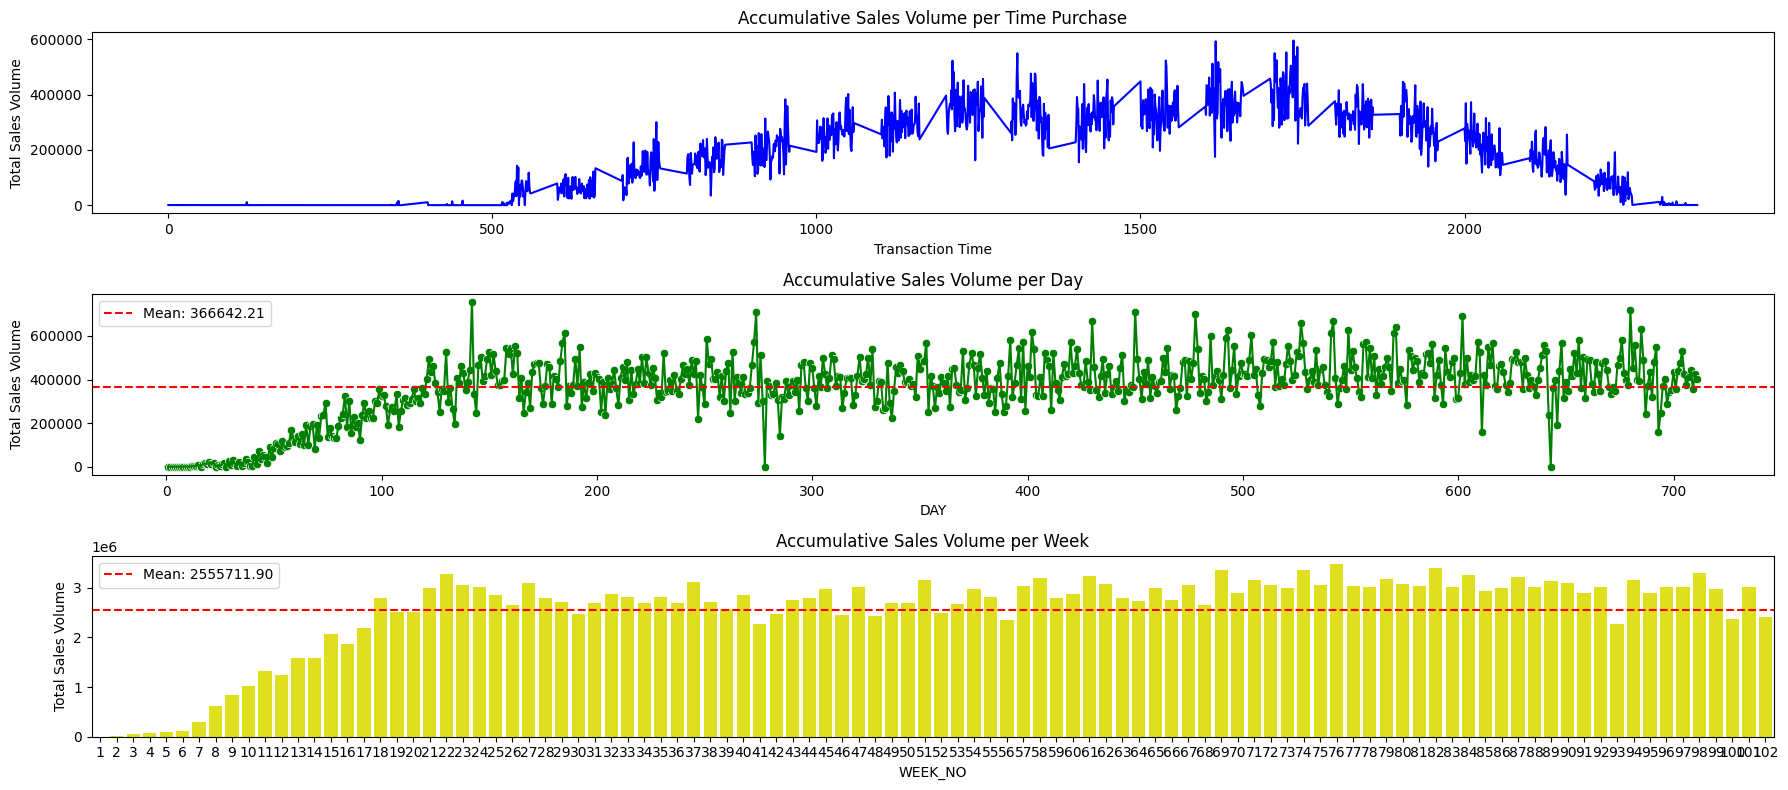

In [110]:
# Seasonality of transaction sales volume
#Explore the Sales Performance per Time
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(18, 8))

# Accumulative Sales Volume per Time Bought
df_time = df.groupby(['TRANS_TIME'], as_index=False).agg({'QUANTITY':'sum'})
sns.lineplot(data=df_time.sort_values('TRANS_TIME'), x='TRANS_TIME', y='QUANTITY', ax=ax1, color='blue')
ax1.set_title('Accumulative Sales Volume per Time Purchase')
ax1.set_xlabel('Transaction Time')
ax1.set_ylabel('Total Sales Volume')

# Accumulative Sales Volume per Day
df_day = df.groupby(['DAY'], as_index=False).agg({'QUANTITY':'sum'})
mean_day_quantity = df_day['QUANTITY'].mean()  #Calculate mean average daily sales
sns.scatterplot(data=df_day.sort_values('DAY'), x='DAY', y='QUANTITY', ax=ax2, color='green')
sns.lineplot(data=df_day.sort_values('DAY'), x='DAY', y='QUANTITY', ax=ax2, color='green')
ax2.axhline(mean_day_quantity, color='red', linestyle='--', label=f'Mean: {mean_day_quantity:.2f}')
ax2.set_title('Accumulative Sales Volume per Day')
ax2.legend()
ax2.set_ylabel('Total Sales Volume')


# Accumulative Sales Volume per Week
df_week = df.groupby(['WEEK_NO'], as_index=False).agg({'QUANTITY':'sum'})
mean_quantity = df_week['QUANTITY'].mean()  #Calculate mean average weekly sales
sns.barplot(data=df_week.sort_values('WEEK_NO'), x='WEEK_NO', y='QUANTITY', ax=ax3, color='yellow')
ax3.axhline(mean_quantity, color='red', linestyle='--', label=f'Mean: {mean_quantity:.2f}')
ax3.set_title('Accumulative Sales Volume per Week')
ax3.set_ylabel('Total Sales Volume')

plt.legend()
plt.tight_layout()


The highest volume of transactions occurs between 10:00 AM and 8:00 PM, indicating that this time range is the busiest period for customer activity. This could align with typical shopping hours or promotional events during the day.

A distinct seasonality pattern is evident, with certain days showing higher sales volumes. This suggests periods of increased customer activity, possibly driven by leisure shopping, promotions, or other factors. However, due to data limitations, it is unclear whether these patterns are tied to weekdays or weekends.

The weekly sales plot demonstrates relatively consistent transaction volumes, reflecting a stable baseline of customer purchases. However, occasional outliers are present, indicating weeks of unusually high sales—possibly driven by specific events, holidays, or marketing campaigns. 

Which are the top most frequent department, commodity, and product being purchased?

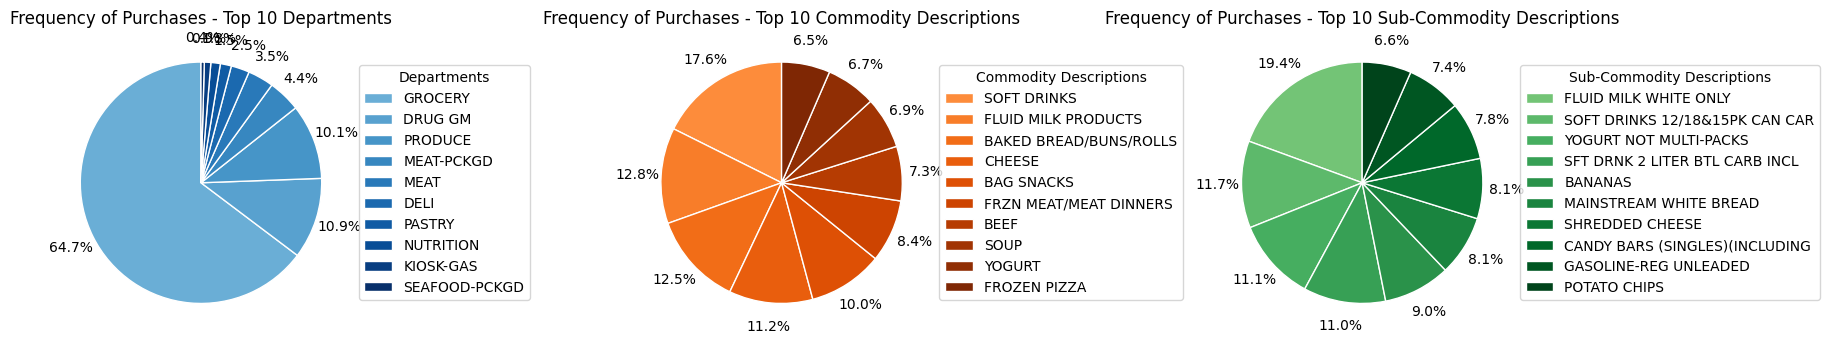

In [111]:
fig, axs = plt.subplots(1, 3, figsize=(18, 18))

# Generate color palettes
colors_department = [cm.Blues(i) for i in np.linspace(0.5, 1, 10)]  # Blue shades
colors_commodity = [cm.Oranges(i) for i in np.linspace(0.5, 1, 10)]  # Orange shades
colors_sub_commodity = [cm.Greens(i) for i in np.linspace(0.5, 1, 10)]  # Green shades

# Frequency of Purchases per Department
df_department = df.groupby(['DEPARTMENT'], as_index=False).size()
df_department = df_department.sort_values('size', ascending=False).head(10)
wedges, _, _ = axs[0].pie(
    df_department['size'],
    autopct=lambda p: f'{p:.1f}%',
    startangle=90,
    pctdistance=1.2,
    colors=colors_department,  # Custom colors
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
axs[0].legend(wedges, df_department['DEPARTMENT'], title="Departments", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
axs[0].set_title('Frequency of Purchases - Top 10 Departments')

# Frequency of Purchases per Commodity Description
df_commodity = df.groupby(['COMMODITY_DESC'], as_index=False).size()
df_commodity = df_commodity.sort_values('size', ascending=False).head(10)
wedges, _, _ = axs[1].pie(
    df_commodity['size'],
    autopct=lambda p: f'{p:.1f}%',
    startangle=90,
    pctdistance=1.2,
    colors=colors_commodity,  # Custom colors
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
axs[1].legend(wedges, df_commodity['COMMODITY_DESC'], title="Commodity Descriptions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
axs[1].set_title('Frequency of Purchases - Top 10 Commodity Descriptions')

# Frequency of Purchases per Sub-Commodity Description
df_sub_commodity = df.groupby(['SUB_COMMODITY_DESC'], as_index=False).size()
df_sub_commodity = df_sub_commodity.sort_values('size', ascending=False).head(10)
wedges, _, _ = axs[2].pie(
    df_sub_commodity['size'],
    autopct=lambda p: f'{p:.1f}%',
    startangle=90,
    pctdistance=1.2,
    colors=colors_sub_commodity,  # Custom colors
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
axs[2].legend(wedges, df_sub_commodity['SUB_COMMODITY_DESC'], title="Sub-Commodity Descriptions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
axs[2].set_title('Frequency of Purchases - Top 10 Sub-Commodity Descriptions')

plt.tight_layout()
plt.show()

From the EDA, we can see there are certain factors in deciding which factor might contribute to the sales volume. We have to include an indicator of seasonality (DAY), store cluster information.

<a id="cd_dd"></a>
<h3>Data Distribution</h3>

In [112]:
# some models does not need standardisation
predictors_col_en = ['DAY','QUANTITY','PRODUCT_PRICE',
       'COUPON_FLAG', 'Cluster', 'display_1', 'display_2',
       'display_3', 'display_4', 'display_5', 'display_6', 'display_7',
       'display_9', 'display_A', 'mailer_A', 'mailer_C', 'mailer_D',
       'mailer_F', 'mailer_H', 'mailer_J', 'mailer_L', 'mailer_X', 'mailer_Z',
       'DEPARTMENT_en', 'COMMODITY_DESC_en', 'SUB_COMMODITY_DESC_en',
       'BRAND_en', 'INTERACTION_en']

# some models senstive to standardisation
predictors_col_en_std = ['QUANTITY_std', 'DEPARTMENT_en_std',
       'COUPON_FLAG','Cluster','BRAND_en',
       'COMMODITY_DESC_en_std', 'SUB_COMMODITY_DESC_en_std',
       'INTERACTION_en_std', 'PRODUCT_PRICE_std', 'DAY_std','display_1', 'display_2',
       'display_3', 'display_4', 'display_5', 'display_6', 'display_7',
       'display_9', 'display_A', 'mailer_A', 'mailer_C', 'mailer_D',
       'mailer_F', 'mailer_H', 'mailer_J', 'mailer_L', 'mailer_X', 'mailer_Z']

col_target_en = 'QUANTITY'
col_target_en_std = 'QUANTITY_std'

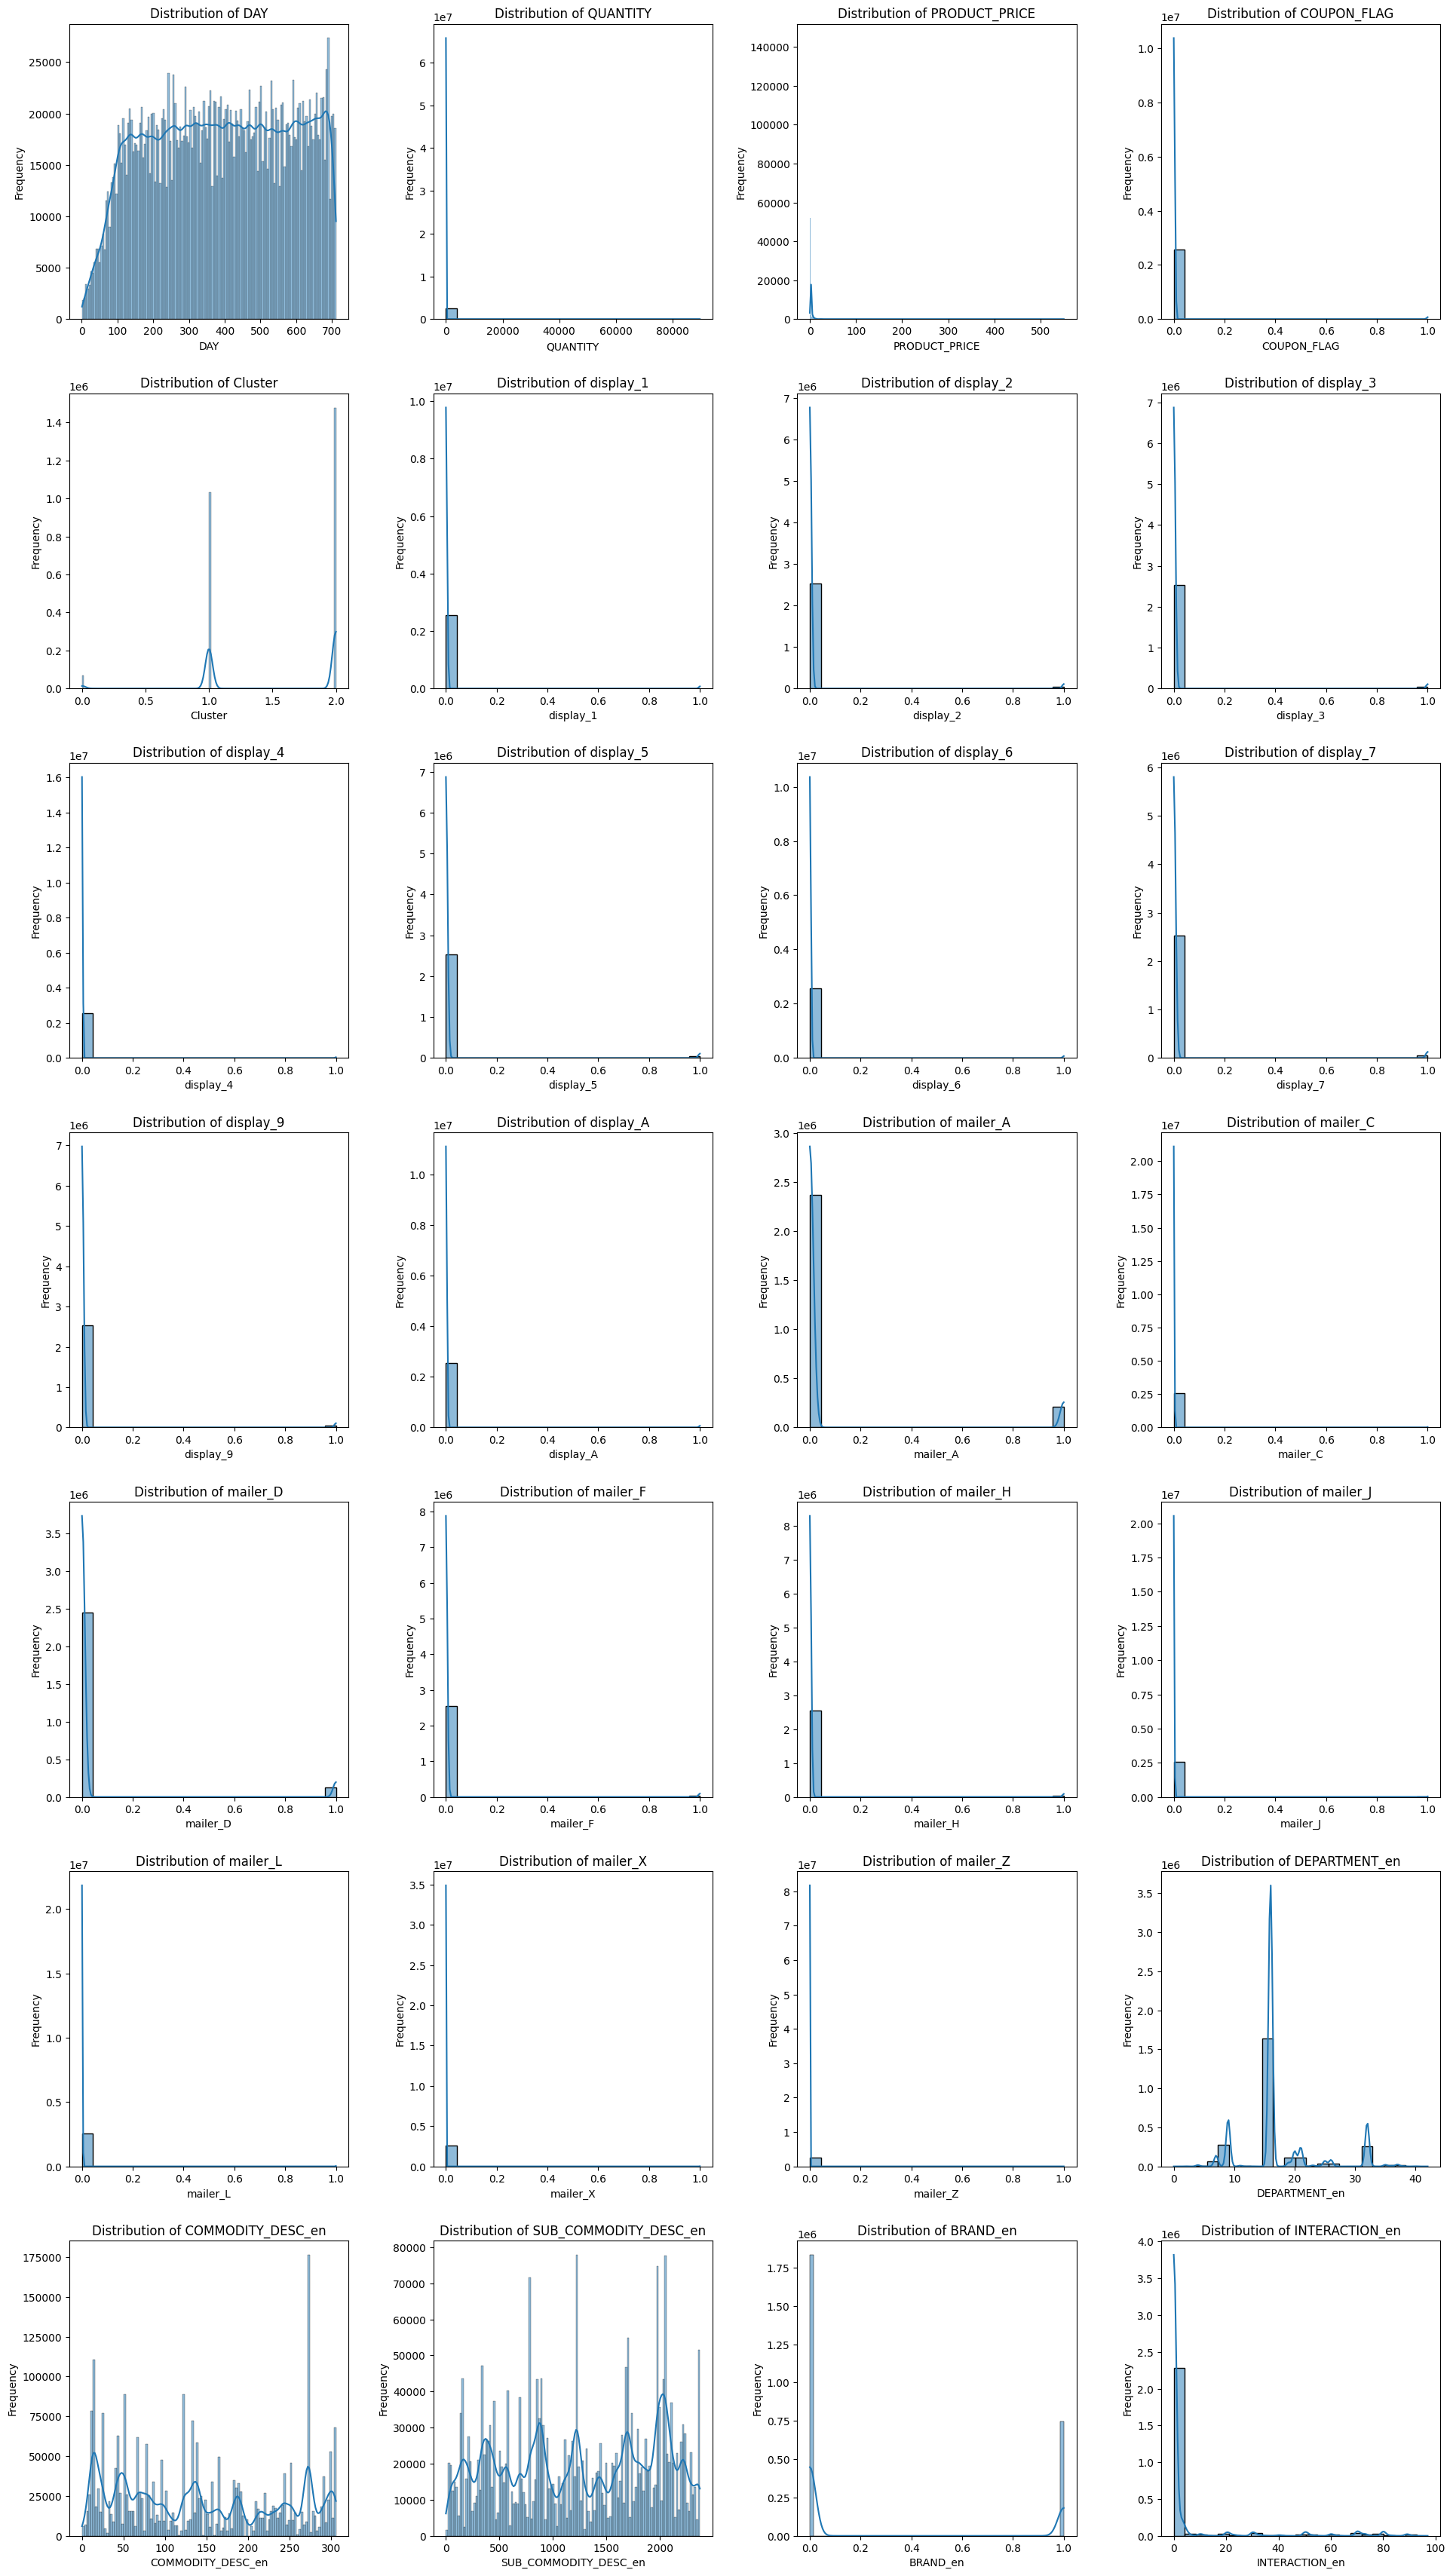

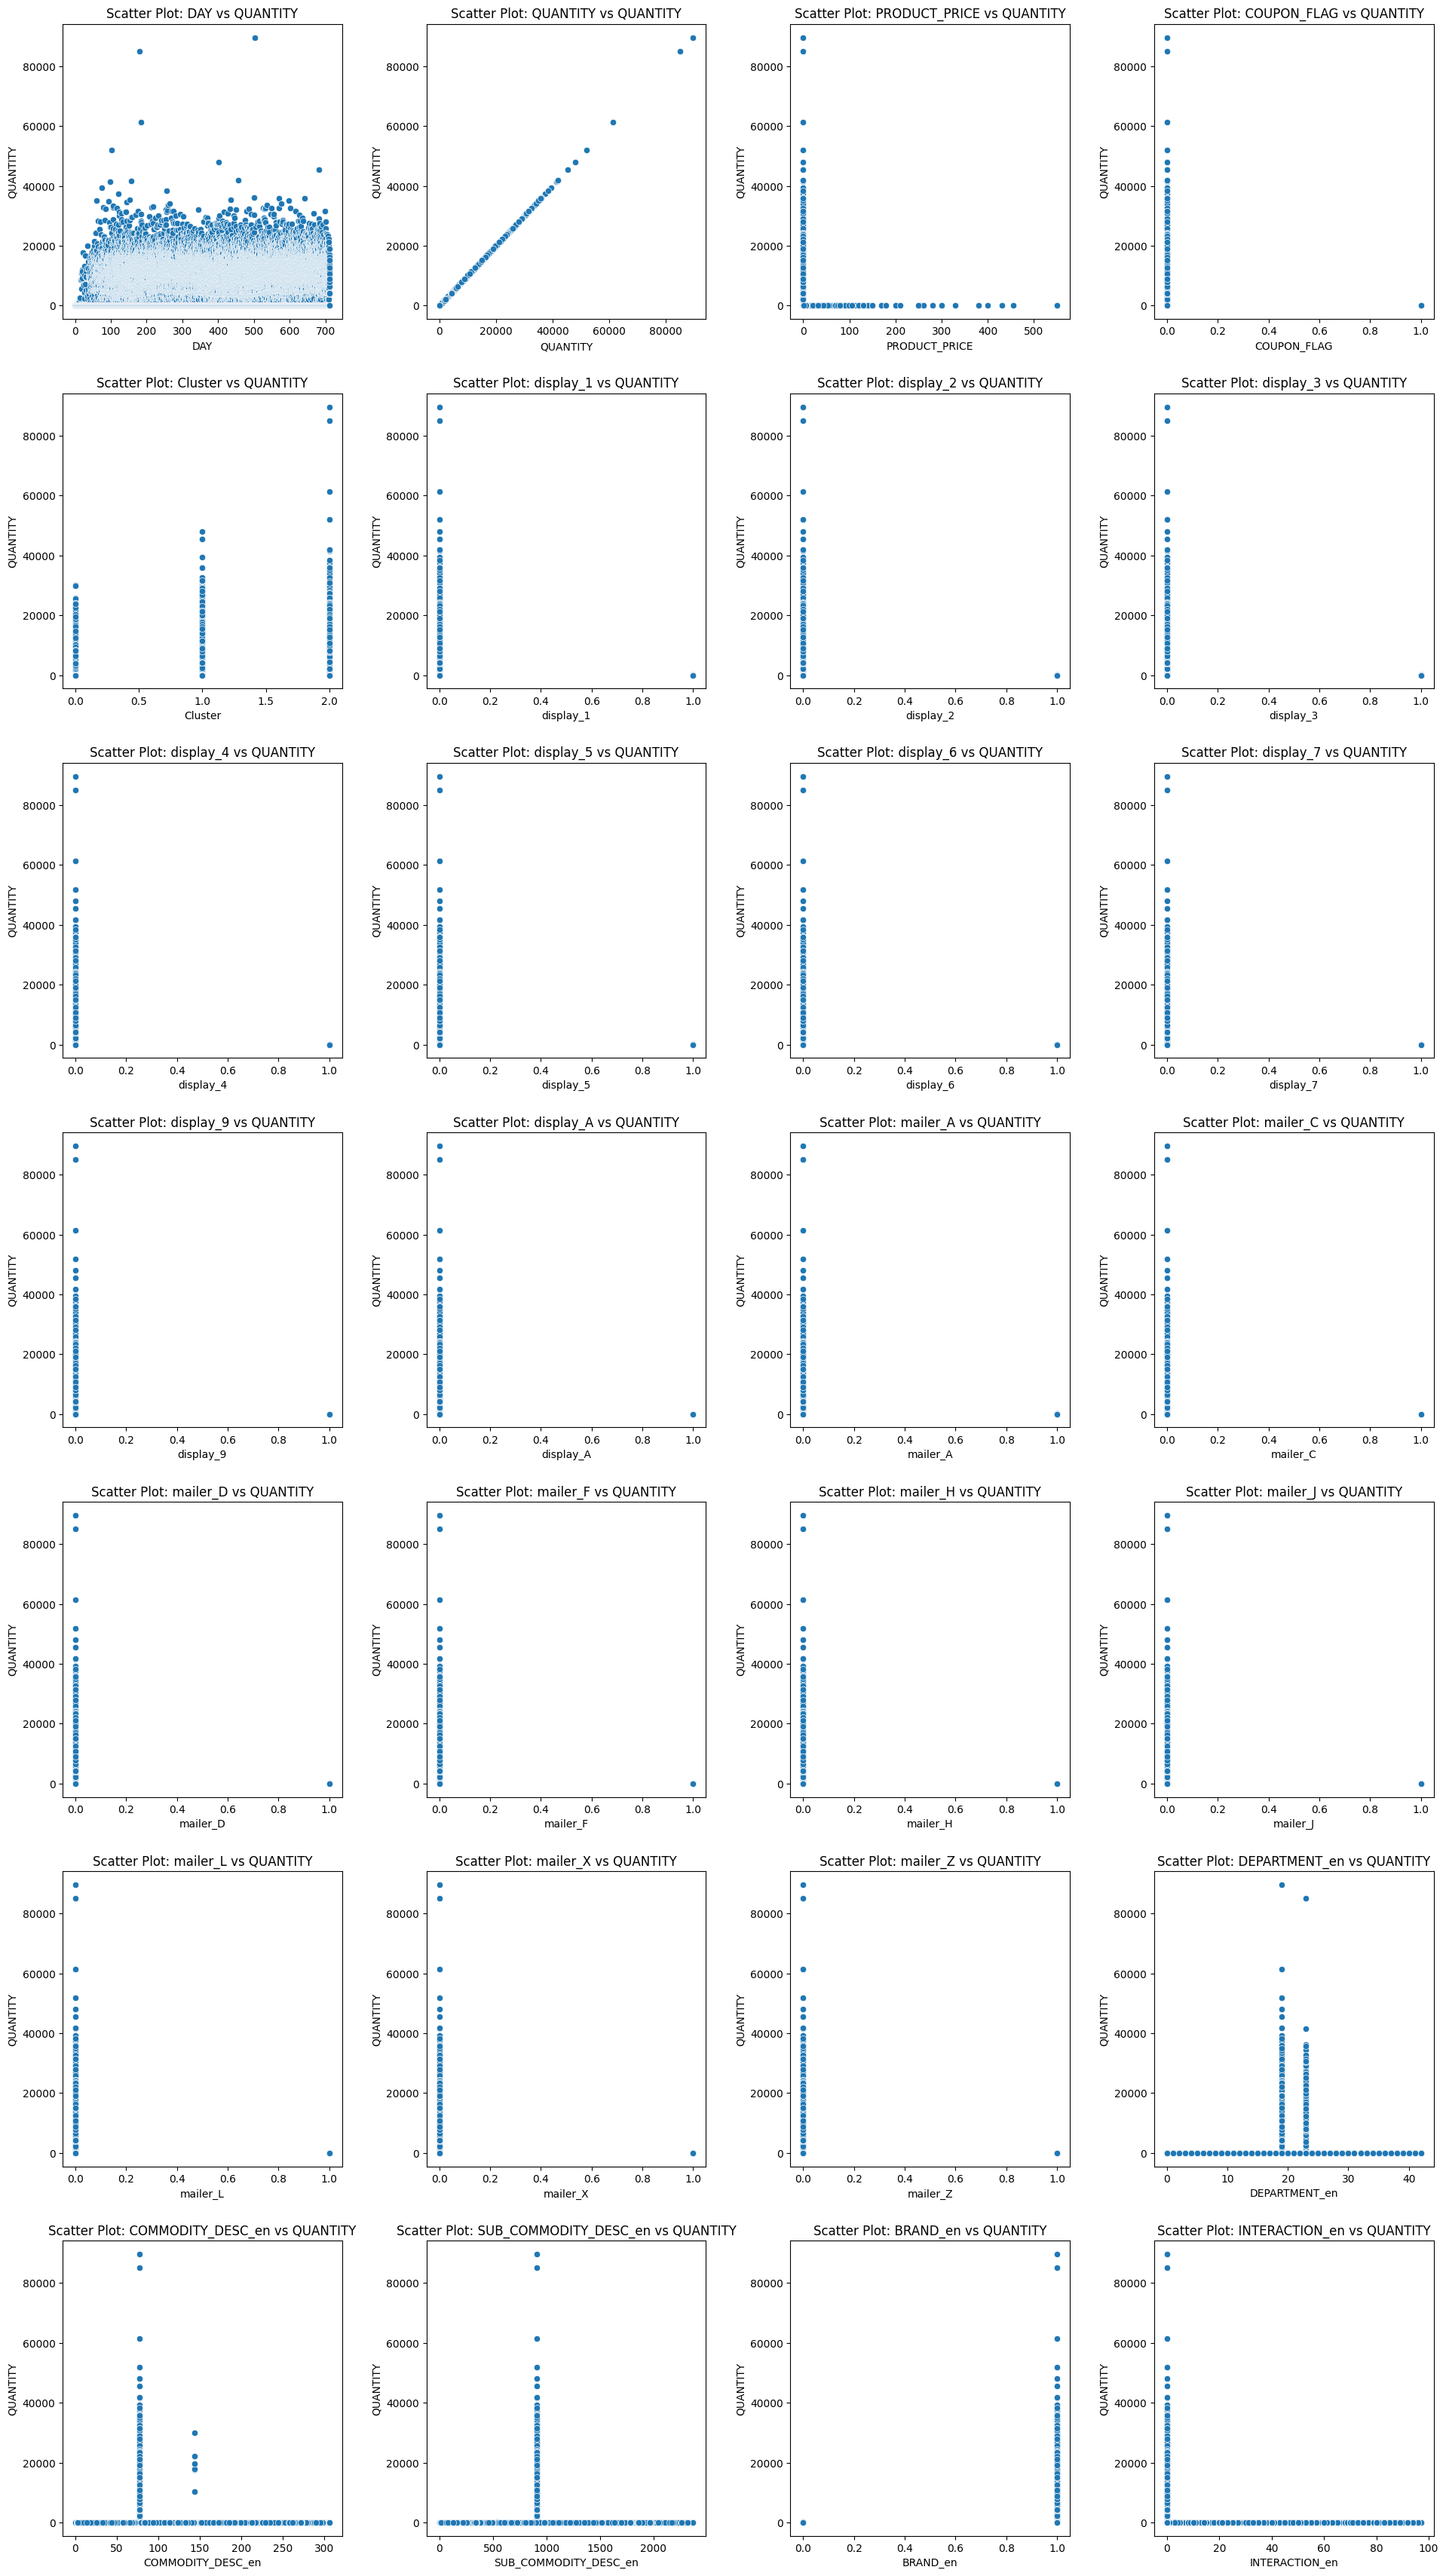

In [113]:
# Data Distribution Plotting - before std

# Determine grid size for subplots
num_cols = 4  
cols_plot = predictors_col_en
num_rows = math.ceil(len(cols_plot) / num_cols)

# Set up the figure for data distribution (Figure 1)
fig1, axs1 = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
fig1.tight_layout(pad=5.0)

axs1 = axs1.flatten()

for i, col in enumerate(cols_plot):
    sns.histplot(df[col], kde=True, ax=axs1[i])
    axs1[i].set_title(f"Distribution of {col}")
    axs1[i].set_xlabel(col)
    axs1[i].set_ylabel('Frequency')

# Remove empty subplots
for j in range(len(cols_plot), len(axs1)):
    fig1.delaxes(axs1[j])

# Set up the figure for scatter plots (Figure 2)
fig2, axs2 = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
fig2.tight_layout(pad=5.0)


axs2 = axs2.flatten()

for i, col in enumerate(cols_plot):
    sns.scatterplot(data=df, x=col, y=col_target_en, ax=axs2[i])
    axs2[i].set_title(f"Scatter Plot: {col} vs {col_target_en}")
    axs2[i].set_xlabel(col)
    axs2[i].set_ylabel(col_target_en)

# Remove empty subplots
for j in range(len(cols_plot), len(axs2)):
    fig2.delaxes(axs2[j])

plt.show()

<a id="eda_corr"></a>
<h3>Correlation Anlaysis</h3>

Text(0.5, 1.0, 'Correlation Analysis - Before Standardisation')

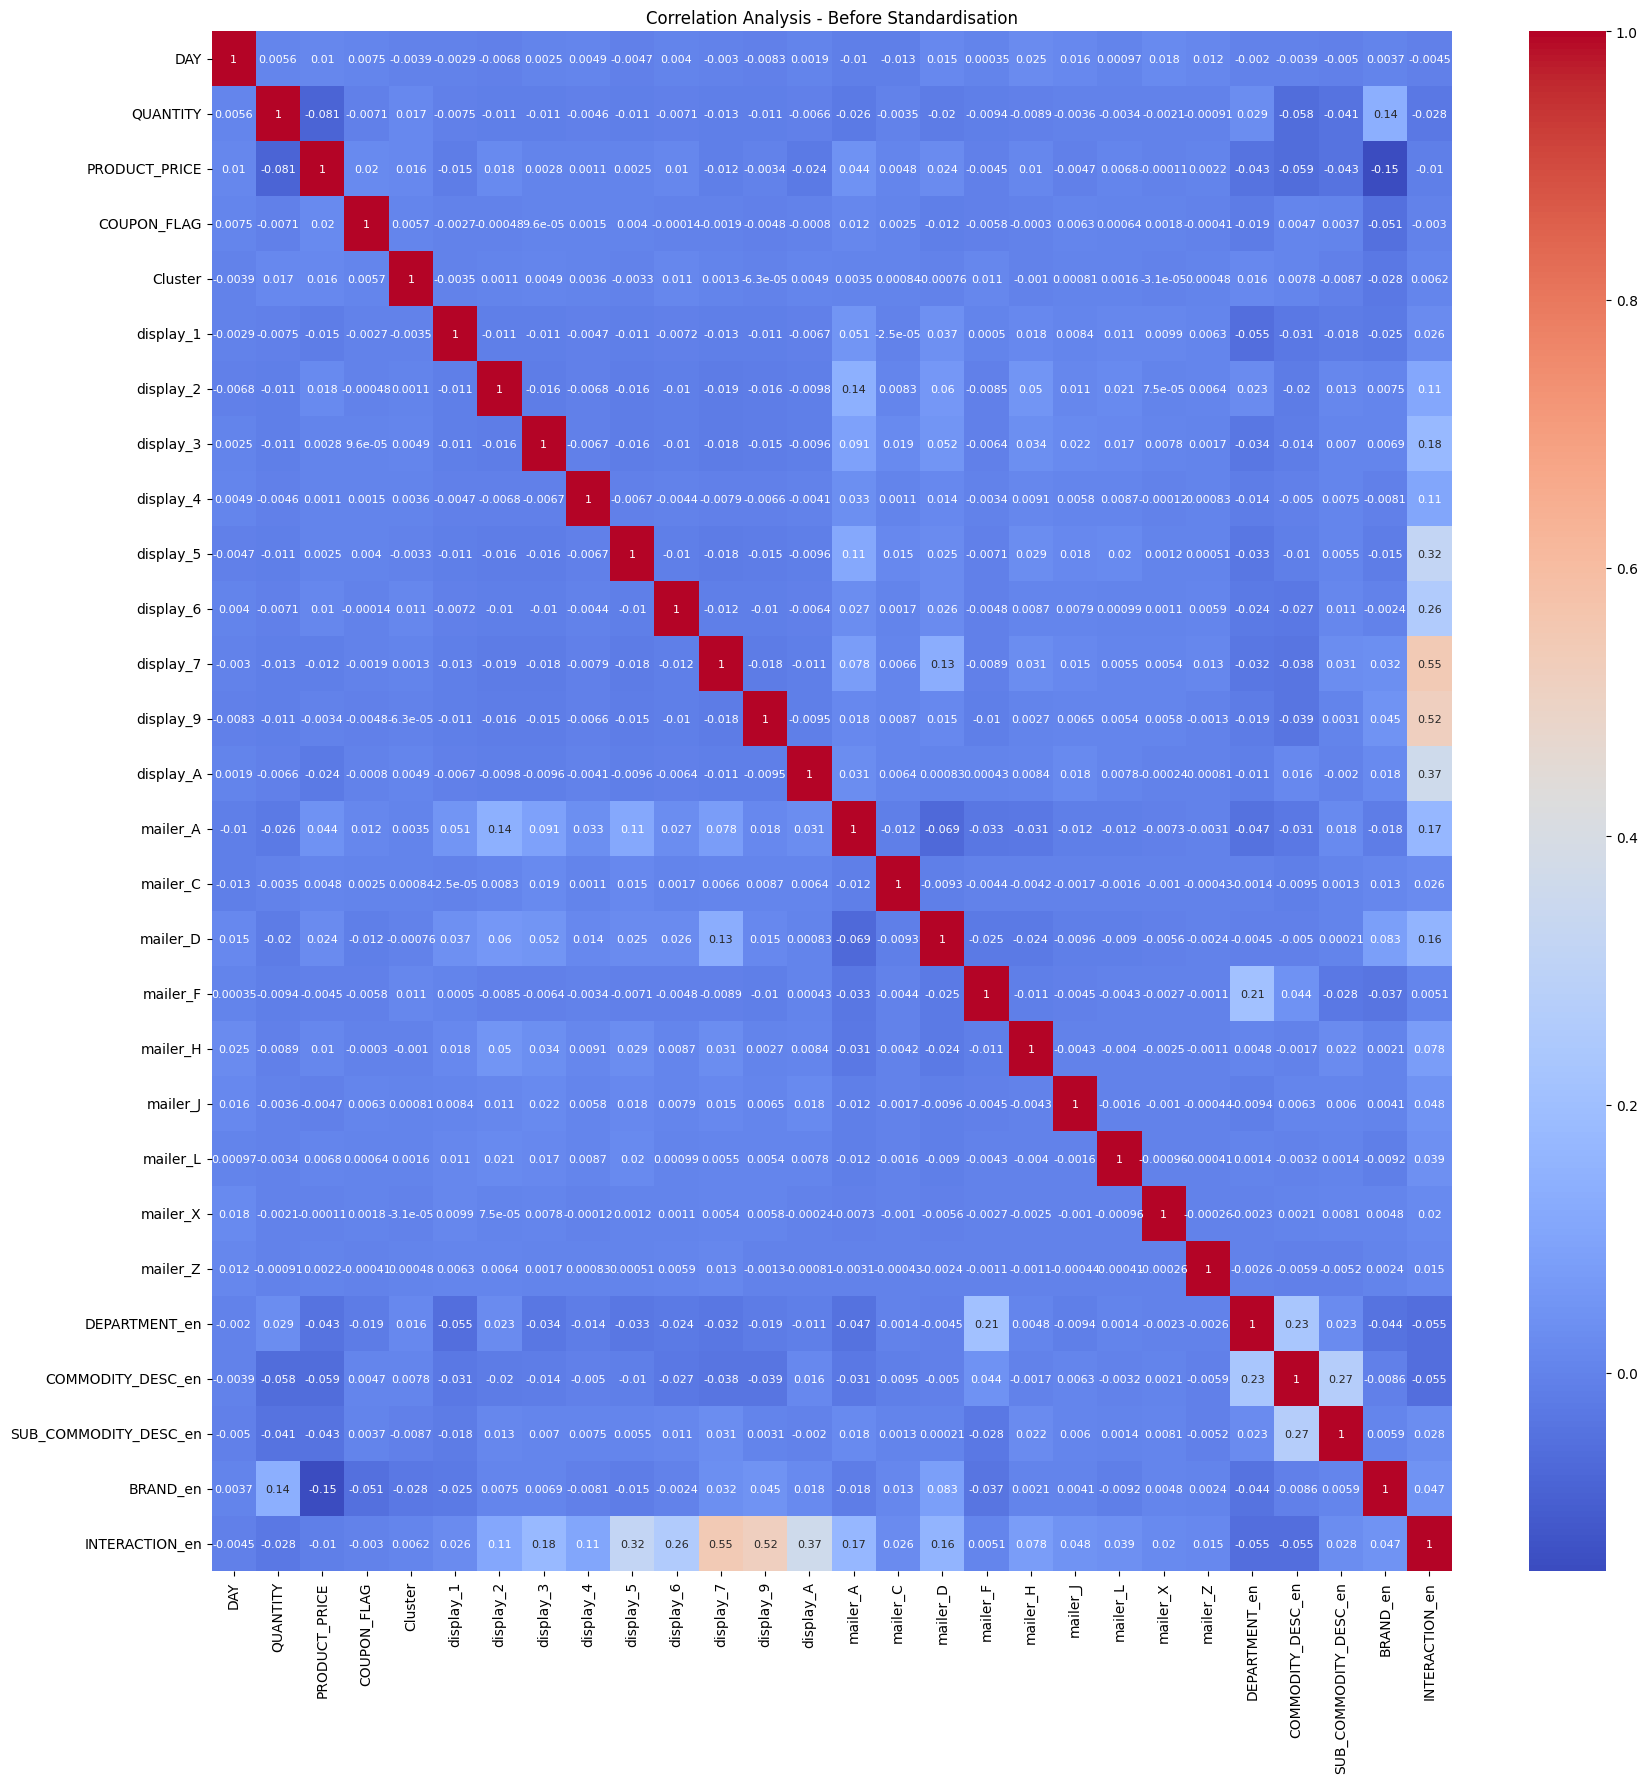

In [114]:
# Correlation Analysis before standardisation

plt.figure(figsize=(20,20))
sns.heatmap(data=df[predictors_col_en].corr(),annot=True, cmap='coolwarm',annot_kws={'fontsize':8})
plt.title('Correlation Analysis - Before Standardisation')

Text(0.5, 1.0, 'Correlation Analysis - After Standrdisation')

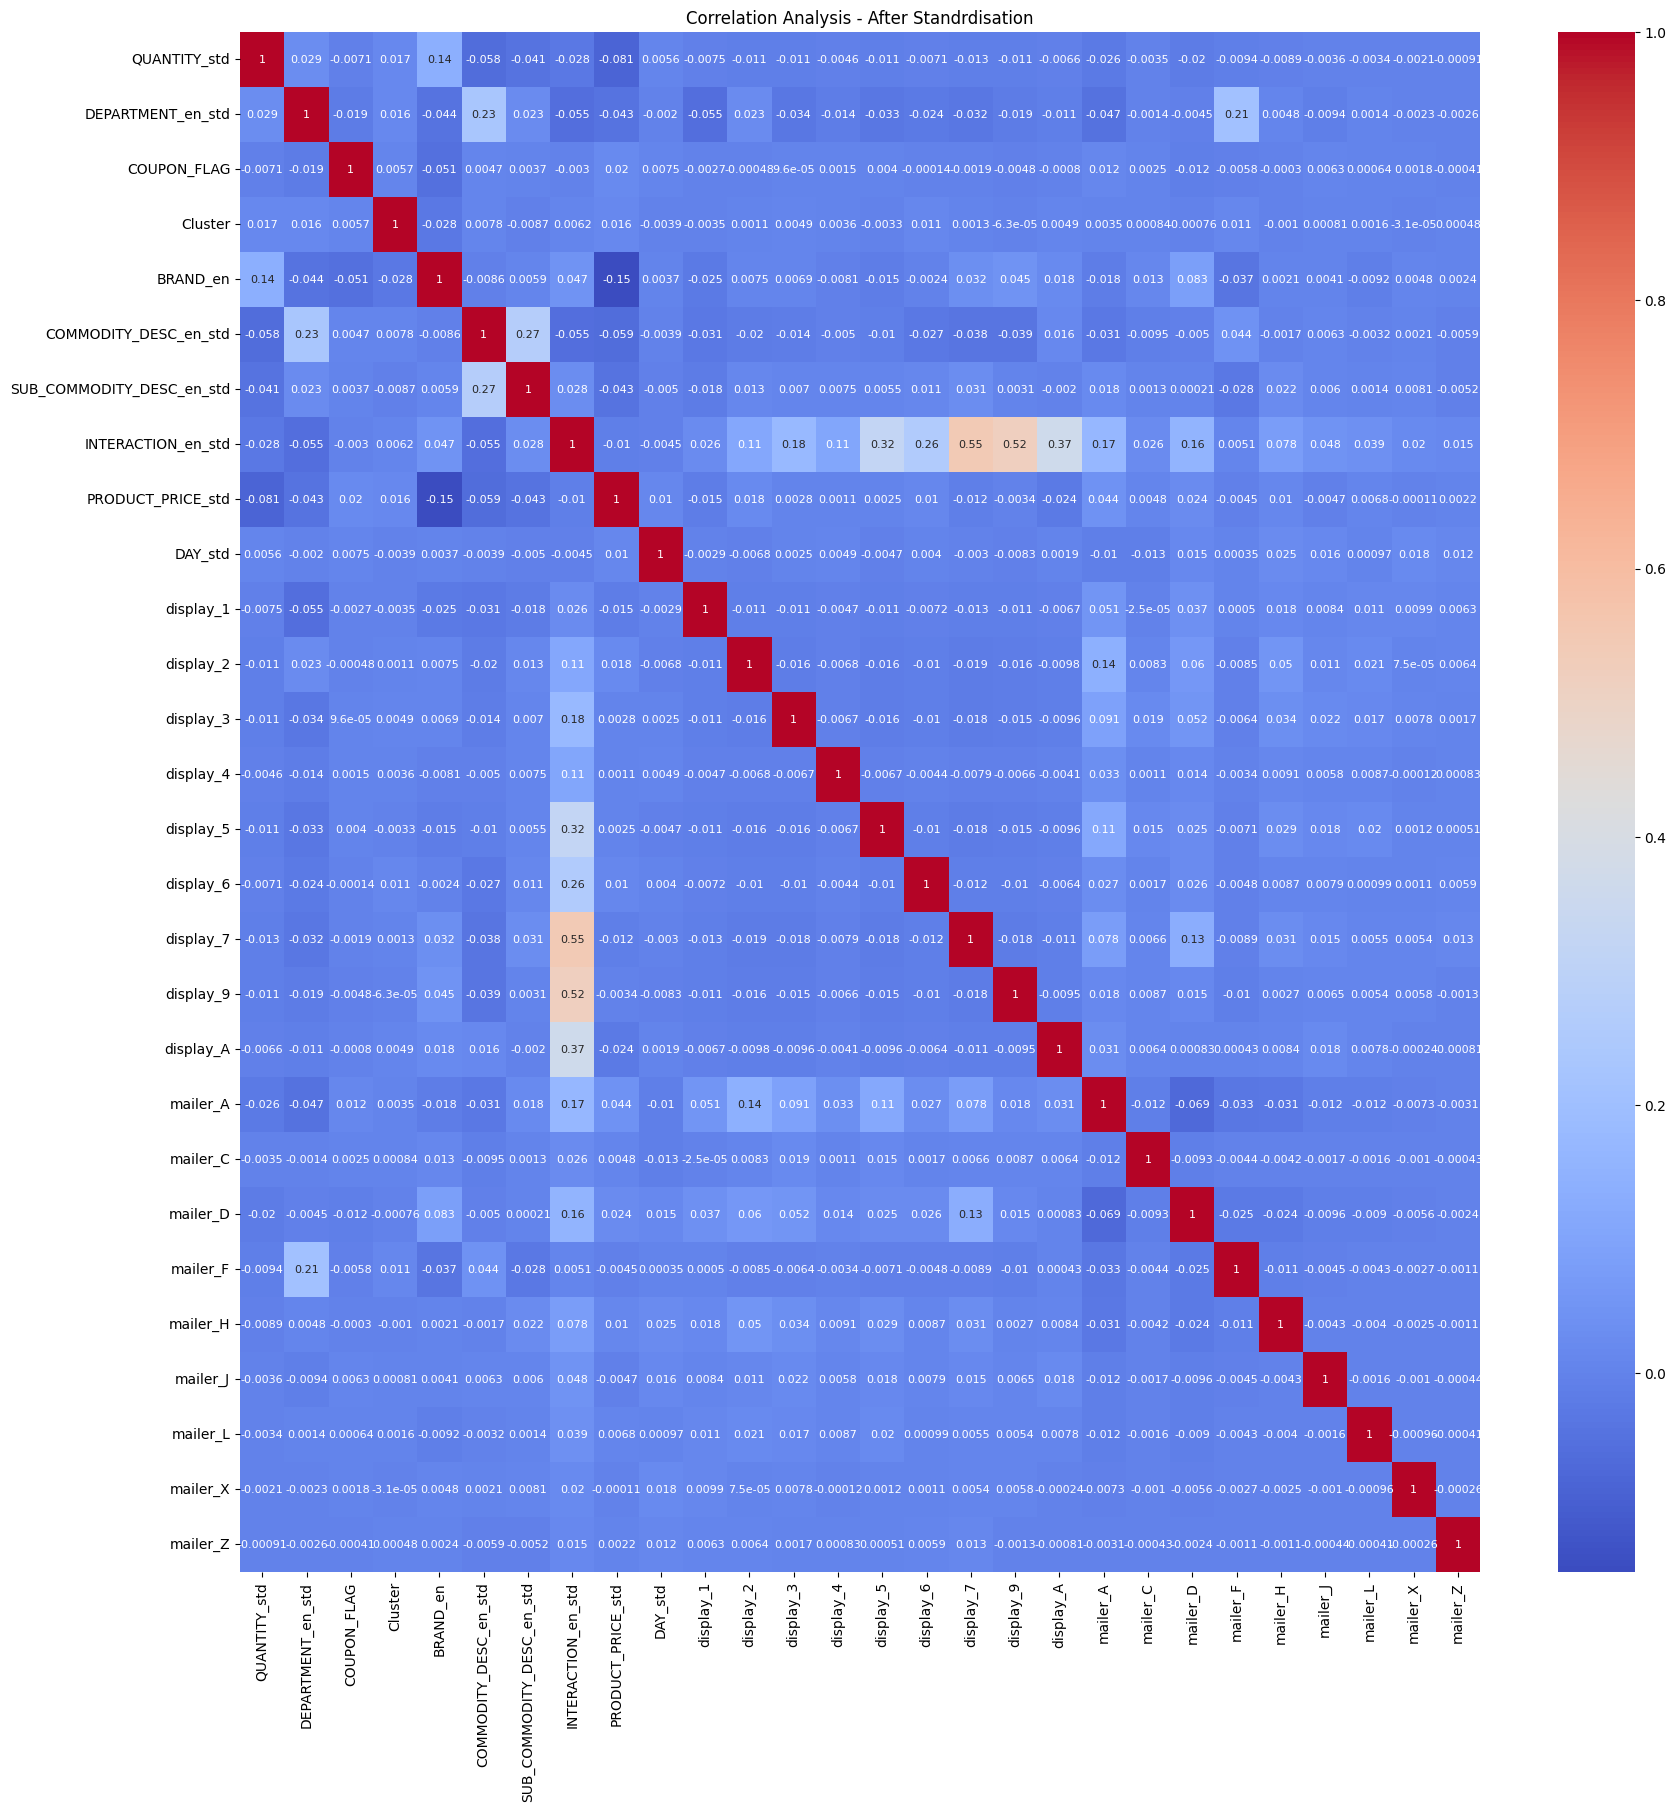

In [115]:
# Correlation Analysis after standardisation

plt.figure(figsize=(20,20))
sns.heatmap(data=df[predictors_col_en_std].corr(),annot=True, cmap='coolwarm',annot_kws={'fontsize':8})
plt.title('Correlation Analysis - After Standrdisation')

<a id="split"></a>
<h2>Data Splitting and Experimentation Workflow</h2>

Data contains day information to capture the trend seasonality, therfore time series split is more suitable than the usual random train_test_split.

Since we have large number of data (>2mio), we have to be wise in using the data since it will consume a lot of computing power. Therfore, we need to formulate the experimentation workflow.

Experimentation Workflow
1. Experiment Part 1 
- use 30% of the first part of dataset as the training dataset and 10% of the next part of dataset as the testing dataset (In total using the 40% of the data)
- Perform OLS and Random Forest with default parameter
- Compare the R2 score and RMSE performance
- Plotting the result (Actual vs Prediction, Prediction vs Residuals, Day vs Prediction & Actual)
- For OLS, inspect on the hypothesting t-test result to see the significance of the predictors
- For Random Forest, inspect on feature importance, to see the rank of importance between the predictors


From here we will choose one of the model that will be optimized

2. Experiment Part 2
- Use the 30% of the first part dataset to find the optimum parameter
- Use 70% of the first part of the dataset as in-sample training data and 30% the tails as out-of-sample testing data and use the optimum parameter
- Use the time series cross validation of the in-sample training data as a measure of the robustness of the model
- Take note on the r2 and rmse performance for each cross validation
- Apply the model from the 70% in-sample for the 30% out-of-sample testing data
- Plotting the result (Actual vs Prediction, Prediction vs Residuals, Day vs Prediction & Actual)

Save the output of the model to be used in production

Visualiztion of Data Splitting

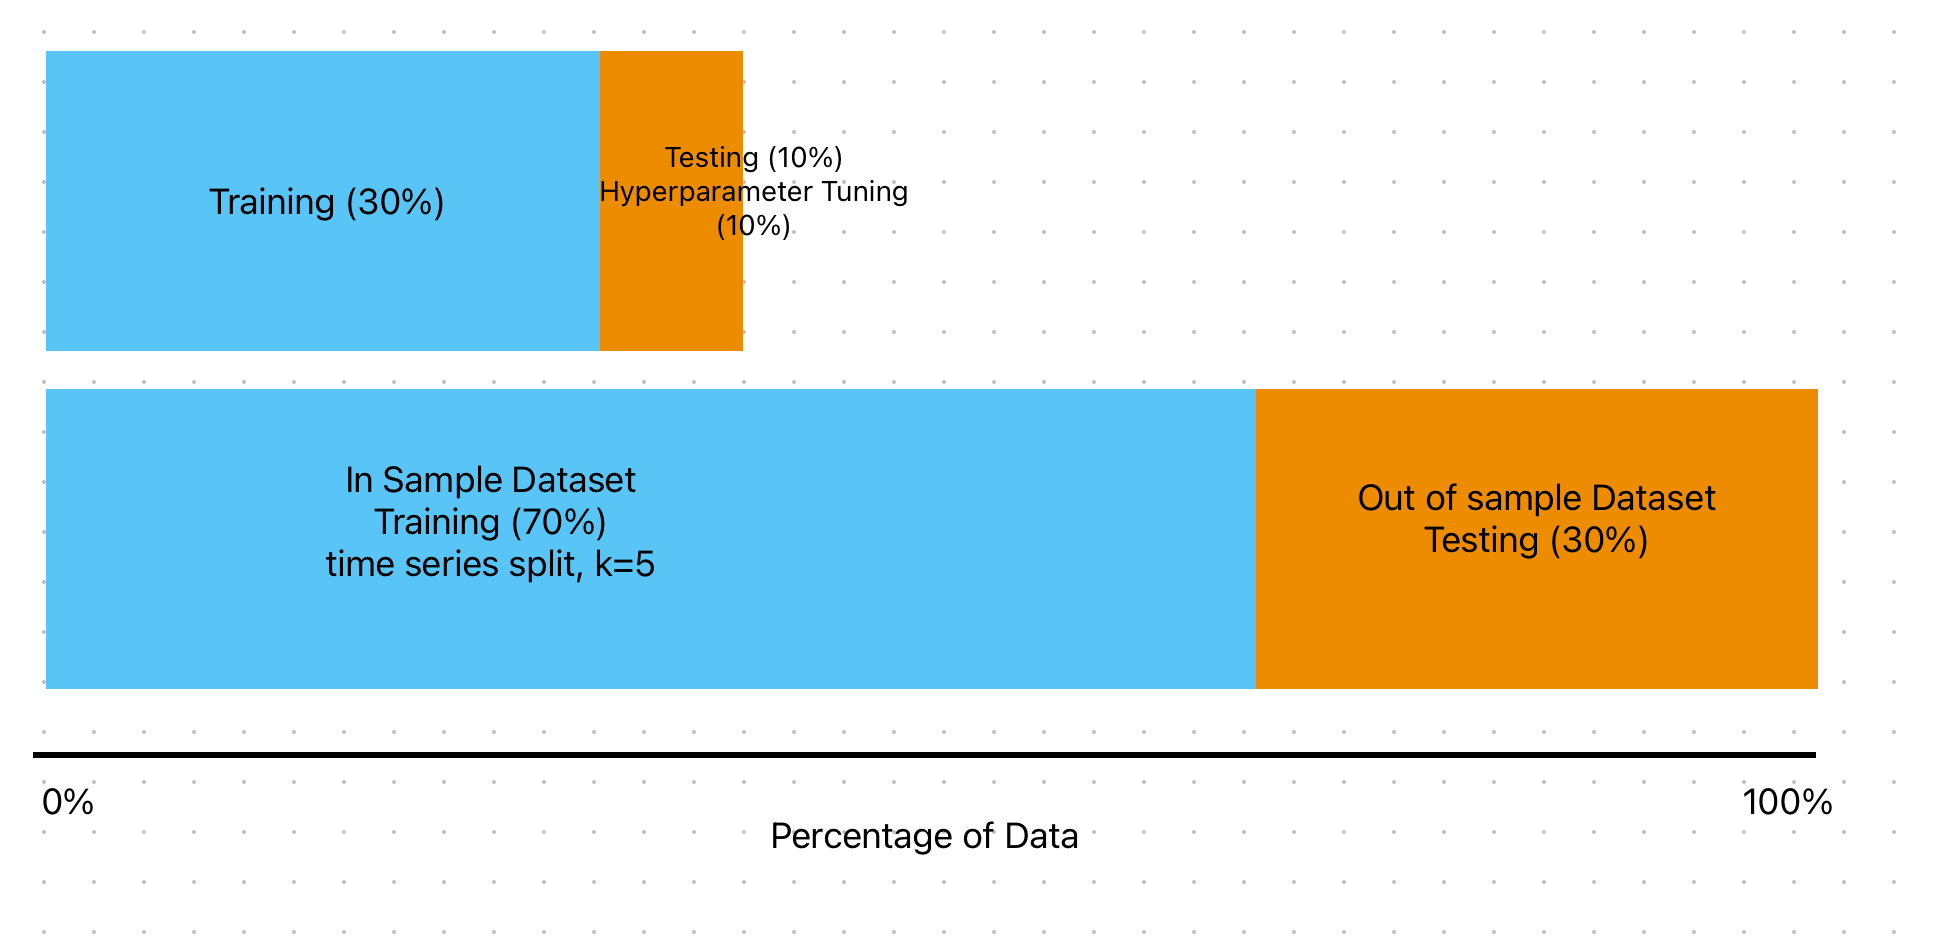



In [116]:
# Subset Size Experiment 1 
subset_size_train_1 = round(len(df)*0.3)
subset_size_test_1 = round(len(df)*0.4)

In [117]:
# Remapping Value of True and False into 0 and 1

bool_cols = ['display_1', 'display_2',
       'display_3', 'display_4', 'display_5', 'display_6', 'display_7',
       'display_9', 'display_A', 'mailer_A', 'mailer_C', 'mailer_D',
       'mailer_F', 'mailer_H', 'mailer_J', 'mailer_L', 'mailer_X', 'mailer_Z']

df[bool_cols] = df[bool_cols].replace({True:1, False:0})

/var/folders/9f/klpz4yzx3hq9bcs22_drg0740000gn/T/ipykernel_45673/3319866770.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].replace({True:1, False:0})


In [118]:
# Defining X and Y for Linear Regression using the Standardized Dataset
X_std = df[predictors_col_en_std].drop('QUANTITY_std', axis=1)
y_std = df['QUANTITY_std']


# Data Splitting
X_train_std, y_train_std = X_std[:subset_size_train_1], y_std[:subset_size_train_1]
X_test_std, y_test_std = X_std[subset_size_train_1:subset_size_test_1], y_std[subset_size_train_1:subset_size_test_1]


In [119]:
# Defining X and Y for Random Forest
X = df[predictors_col_en].drop('QUANTITY', axis=1)
y = df['QUANTITY']


# Data Splitting
X_train, y_train = X[:subset_size_train_1], y[:subset_size_train_1]
X_test, y_test = X[subset_size_train_1:subset_size_test_1], y[subset_size_train_1:subset_size_test_1]


<a id="lr"></a>
Experiment Part 1 - Linear Regression

In [120]:
# Use OLS from statmodels libarary
model_lr = sm.OLS( y_train_std, 
                sm.add_constant(X_train_std))

results = model_lr.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           QUANTITY_std   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     972.0
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:46:58   Log-Likelihood:            -1.0548e+06
No. Observations:              773301   AIC:                         2.110e+06
Df Residuals:                  773275   BIC:                         2.110e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -8.795e+05   1.26e+09     -0.001      0.999   -2.47e+09    2.46e+09
DEPARTMENT_en_std             0.0455      0.001     39.292      0.000       0.043       0.048
COUPON_FLAG                   0.0154      0.014      1.130      0.258      -0.011       0.042
Cluster                       0.0491      0.002     25.057      0.000       0.045       0.053
BRAND_en                      0.2701      0.002    111.126      0.000       0.265       0.275
COMMODITY_DESC_en_std        -0.0633      0.001    -54.561      0.000      -0.066      -0.061
SUB_COMMODITY_DESC_en_std    -0.0240      0.001    -21.332      0.000      -0.026      -0.022
INTERACTION_en_std        -2.727e+06    3.9e+09     -0.001      0.999   -7.65e+09    7.64e+09
PRODUCT_PRICE_std            -0.0610      0.001    -54.373      0.000      -0.063      -0.059
DAY_std                       0.0398      0.003     12.413      0.000       0.033       0.046
display_1                  1.542e+06   2.21e+09      0.001      0.999   -4.32e+09    4.33e+09
display_2                  3.085e+06   4.41e+09      0.001      0.999   -8.64e+09    8.65e+09
display_3                  4.627e+06   6.62e+09      0.001      0.999    -1.3e+10     1.3e+10
display_4                   6.17e+06   8.82e+09      0.001      0.999   -1.73e+10    1.73e+10
display_5                  7.712e+06    1.1e+10      0.001      0.999   -2.16e+10    2.16e+10
display_6                  9.255e+06   1.32e+10      0.001      0.999   -2.59e+10     2.6e+10
display_7                   1.08e+07   1.54e+10      0.001      0.999   -3.03e+10    3.03e+10
display_9                  1.234e+07   1.76e+10      0.001      0.999   -3.46e+10    3.46e+10
display_A                  1.373e+07   1.96e+10      0.001      0.999   -3.85e+10    3.85e+10
mailer_A                   1.542e+05   2.21e+08      0.001      0.999   -4.32e+08    4.33e+08
mailer_C                   3.085e+05   4.41e+08      0.001      0.999   -8.64e+08    8.65e+08
mailer_D                   4.627e+05   6.62e+08      0.001      0.999    -1.3e+09     1.3e+09
mailer_F                    6.17e+05   8.82e+08      0.001      0.999   -1.73e+09    1.73e+09
mailer_H                   7.712e+05    1.1e+09      0.001      0.999   -2.16e+09    2.16e+09
mailer_J                   9.255e+05   1.32e+09      0.001      0.999   -2.59e+09     2.6e+09
mailer_L                    1.08e+06   1.54e+09      0.001      0.999   -3.03e+09    3.03e+09
mailer_X                           0          0        nan        nan           0           0
mailer_Z                           0          0        nan        nan           0           0
==============================================================================
Omnibus:                  1434509.794   Durbin-Watson:                   1.861
Prob(Omnibu

In [121]:
ypred_lr = results.predict(sm.add_constant(X_test_std))

print('R2 Score:', r2_score(y_test_std, ypred_lr.round()))
print('RMSE:', root_mean_squared_error(y_test_std, ypred_lr.round()))

R2 Score: -0.002295380970187777
RMSE: 0.9746198309046705


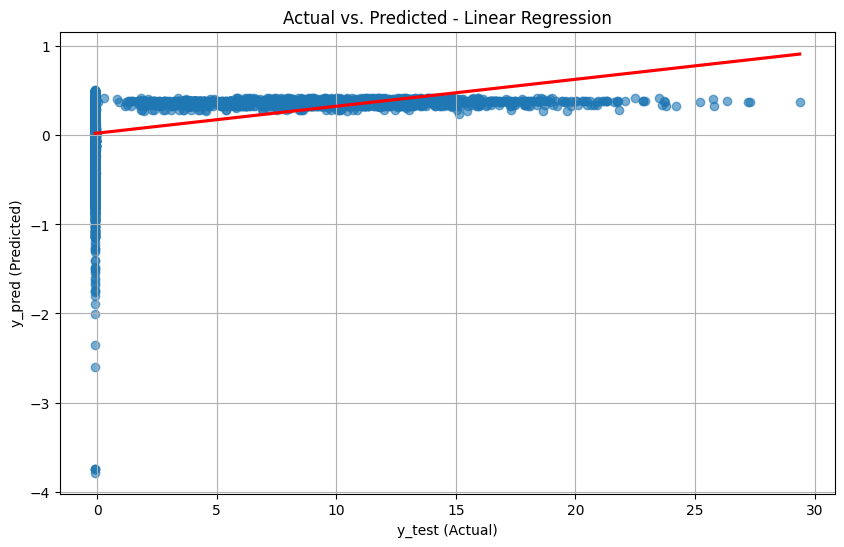

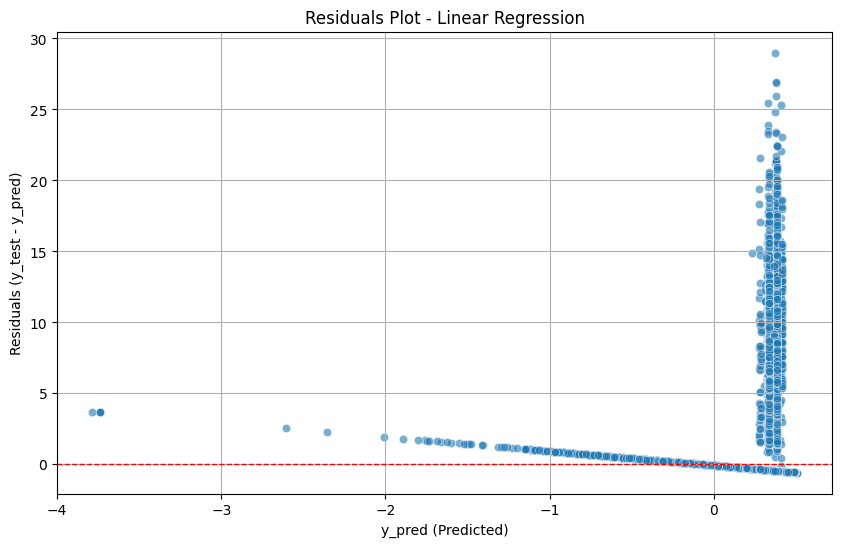

In [122]:
# Visualization Result

# Scatter plot with regression line for y_test vs. y_pred
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test_std, y=ypred_lr, scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})
plt.title("Actual vs. Predicted - Linear Regression")
plt.xlabel("y_test (Actual)")
plt.ylabel("y_pred (Predicted)")
plt.grid(True)
plt.show()

# Calculate residuals
residuals = y_test_std - ypred_lr

# Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ypred_lr, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals Plot - Linear Regression")
plt.xlabel("y_pred (Predicted)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.grid(True)
plt.show()


<a id="rf"></a>
Experiment Part 1 - Random Forest


In [123]:
rf = RandomForestRegressor(random_state=42)

model_rf = rf.fit(X_train, y_train)
ypred_rf = model_rf.predict(X_test)

print('R2 Score:', r2_score(y_test, ypred_rf.round()))
print('RMSE:', root_mean_squared_error(y_test, ypred_rf.round()))

R2 Score: 0.7757146596911236
RMSE: 533.624803229247


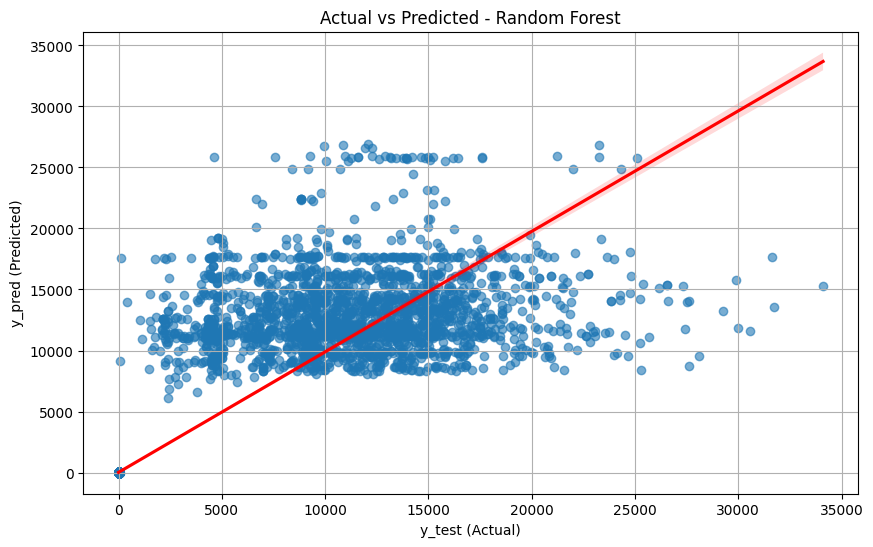

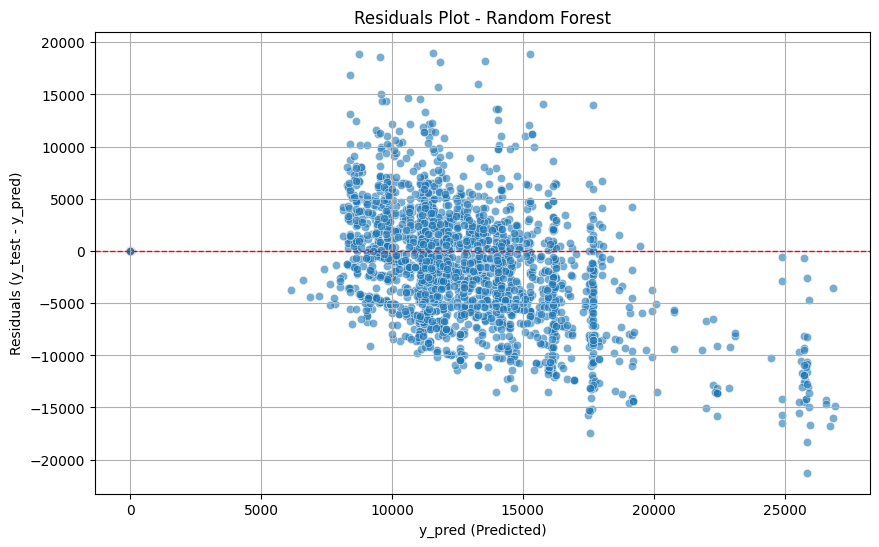

In [124]:
# Visualization Result

# Scatter plot with regression line for y_test vs. y_pred
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=ypred_rf, scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})
plt.title("Actual vs Predicted - Random Forest")
plt.xlabel("y_test (Actual)")
plt.ylabel("y_pred (Predicted)")
plt.grid(True)
plt.show()

# Calculate residuals
residuals = y_test - ypred_rf

# Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ypred_rf, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals Plot - Random Forest")
plt.xlabel("y_pred (Predicted)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.grid(True)
plt.show()


Since the linear and regression use different scale of data, we can only compare the r2 score and the goodness of the model from visualiztions. Linear regession performs poorly with r2 score of -0.002. Random forest perform better, can explain 77% of the varianced, with residuals are distributed normally.

On the next step, we will optimze random forest to improve the model performance.

<a id="mlop"></a>
<h2>Model Optimization</h2>

In [125]:
# Hyperparameter tuning Random Forest 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Parameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define custom scorers
r2_scorer = make_scorer(r2_score)  
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)  # Minimize RMSE

tscv = TimeSeriesSplit(n_splits=2)

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring={
        'R2': r2_scorer,
        'MAPE': rmse_scorer
    },
    cv=tscv,
    refit='R2',  # Optimize for R2
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_test, y_test)

# Best parameters based on the refit metric 
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Accessing the scores for all metrics
cv_results = grid_search.cv_results_

# Display R2 and MAPE for the best model
best_r2 = grid_search.best_score_
print(f"Best R2 Score: {best_r2}")



Fitting 2 folds for each of 81 candidates, totalling 162 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  10.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  21.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  21.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  10.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  42.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  45.0s
[CV] END max_depth=10, min_sample

/Users/febri/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  13.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  27.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  54.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  26.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  12.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  53.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  29.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estima

Best Parameter from the gridsearch cv are

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}

with the performance below:

Best R2 Score: 0.843



Number of rows used in training:  300729
R2 Score:  0.46950671789821286


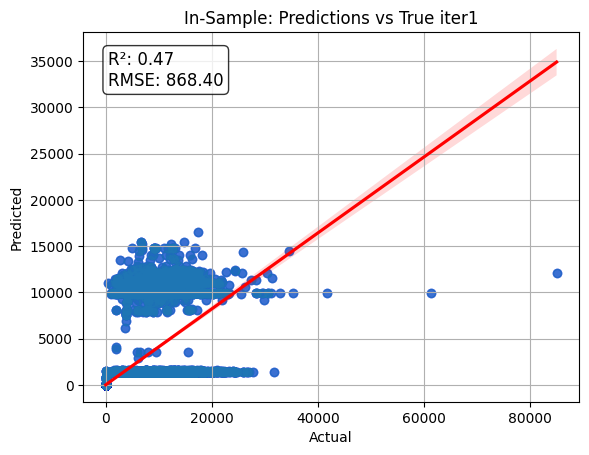

Number of rows used in training:  601457
R2 Score:  0.829964349854076


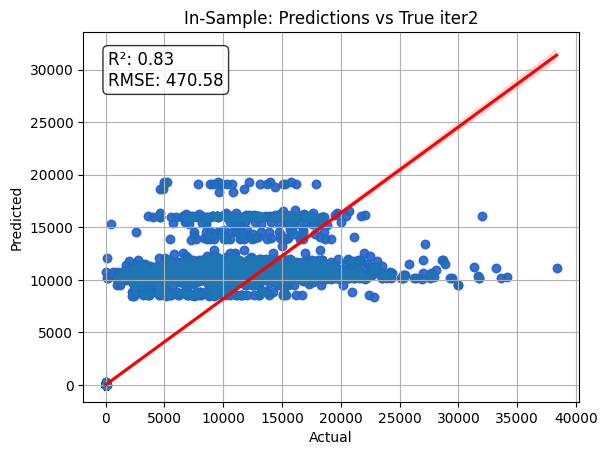

Number of rows used in training:  902185
R2 Score:  0.8386783610726576


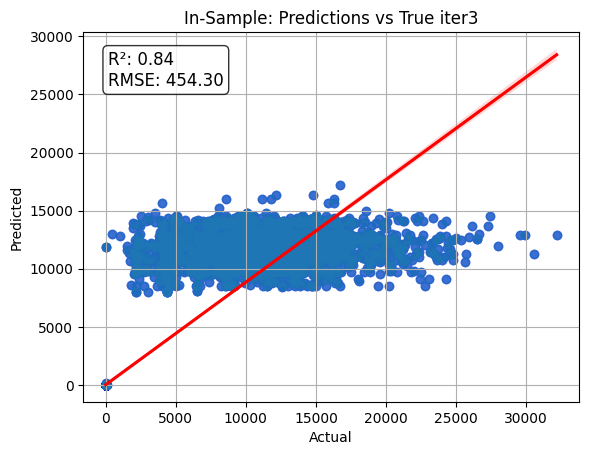

Number of rows used in training:  1202913
R2 Score:  0.7883256679163085


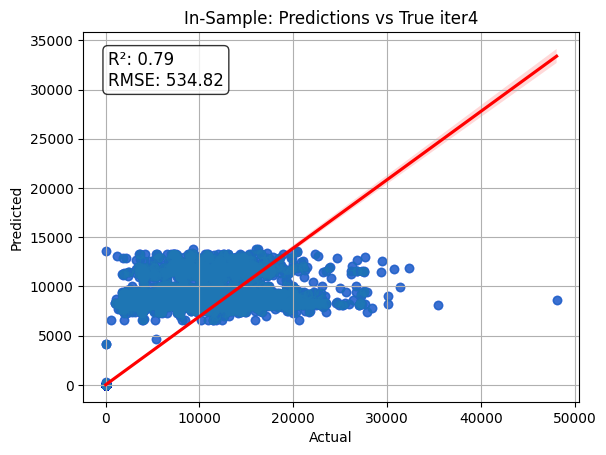

Number of rows used in training:  1503641
R2 Score:  0.8053418343204634


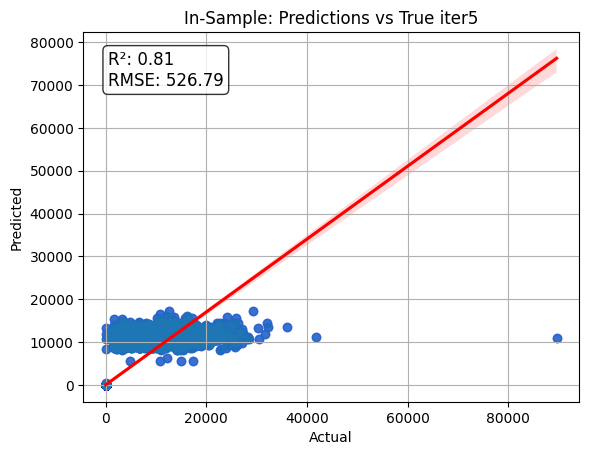

In-Sample R2: 0.74, RMSE: 590.85
Out-of-Sample R2: 0.84, RMSE: 475.90


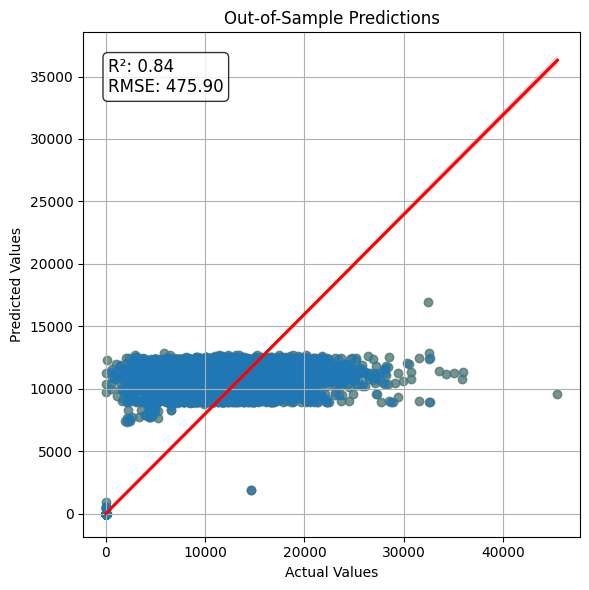

In [127]:
# Part 2 testing model robustness

# Step 1: Split data into in-sample and out-of-sample
in_sample_size = int(len(X) * 0.7)  # First 70% for in-sample
X_in_sample, X_out_sample = X.iloc[:in_sample_size], X.iloc[in_sample_size:]
y_in_sample, y_out_sample = y.iloc[:in_sample_size], y.iloc[in_sample_size:]

# Step 2: Cross-validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store predictions and true values
cv_predictions = []
cv_true = []
i = 1

row_list_day = [] # Storing number of rows within iteration
iter_day = [] # Storing the iteration set
r2_list_day = [] # Storing the result of r2 score
rmse_list_day = [] # Storing the result of mean absolute error

# Initialize Random Forest Regresor with the parameter from the grid search result
model_rfp = RandomForestRegressor(random_state=42,n_estimators=50,
                              max_depth=10,min_samples_leaf=4,
                              min_samples_split=10)



for train_index, val_index in tscv.split(X_in_sample):
    # Split into train and validation sets (preserving time order)
    X_train, X_val = X_in_sample.iloc[train_index], X_in_sample.iloc[val_index]
    y_train, y_val = y_in_sample.iloc[train_index], y_in_sample.iloc[val_index]
    
    print('Number of rows used in training: ' ,len(X_train))
    row_list_day.append(len(X_train))
    iter_day.append(i)
    
    
    # Train the model
    model_rf_hp = model_rfp.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model_rf_hp.predict(X_val)
    
    # Rounding value
    y_pred = y_pred.round()

    # Store predictions and true values
    cv_predictions.extend(y_pred)
    cv_true.extend(y_val)

    r2val = r2_score(y_val,y_pred)
    print('R2 Score: ',r2val)
    r2_list_day.append(r2val)
    rmseval = root_mean_squared_error(y_val, y_pred)
    rmse_list_day.append(rmseval)
    

    # In-sample plot
    plt.scatter(y_val,y_pred, alpha=0.6, color='blue')
    sns.regplot(x=y_val, y=y_pred, scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})

    # Adding R² and RMSE to the plot
    metrics_text = f"R²: {r2val:.2f}\nRMSE: {rmseval:.2f}"
    plt.text(
        0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

    titlef = "In-Sample: Predictions vs True iter"+str(i)
    plt.title(titlef)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()
    i += 1

# Step 3: Train on the full in-sample and test on out-of-sample
insample_model = model_rfp.fit(X_in_sample, y_in_sample)
y_out_sample_pred = insample_model.predict(X_out_sample)

# Step 4: Calculate performance metrics
# In-sample metrics (from cross-validation)
r2_in_sample = r2_score(cv_true, cv_predictions)
rmse_in_sample = root_mean_squared_error(cv_true, cv_predictions)

# Out-of-sample metrics
r2_out_sample = r2_score(y_out_sample, y_out_sample_pred)
rmse_out_sample = root_mean_squared_error(y_out_sample, y_out_sample_pred)

print(f"In-Sample R2: {r2_in_sample:.2f}, RMSE: {rmse_in_sample:.2f}")
print(f"Out-of-Sample R2: {r2_out_sample:.2f}, RMSE: {rmse_out_sample:.2f}")

# Step 6: Plot the results
plt.figure(figsize=(6, 6))



# Out-of-sample plot
plt.scatter(y_out_sample, y_out_sample_pred, alpha=0.7, color='orange')
sns.regplot(x=y_out_sample, y=y_out_sample_pred, scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})

# Adding R² and RMSE to the plot
metrics_text = f"R²: {r2_out_sample:.2f}\nRMSE: {rmse_out_sample:.2f}"
plt.text(
    0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
    fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.title('Out-of-Sample Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.grid(True)
plt.show()

/var/folders/9f/klpz4yzx3hq9bcs22_drg0740000gn/T/ipykernel_45673/3504991591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_result['actual'] = y_out_sample
/var/folders/9f/klpz4yzx3hq9bcs22_drg0740000gn/T/ipykernel_45673/3504991591.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_result['prediction'] = np.round(y_out_sample_pred)


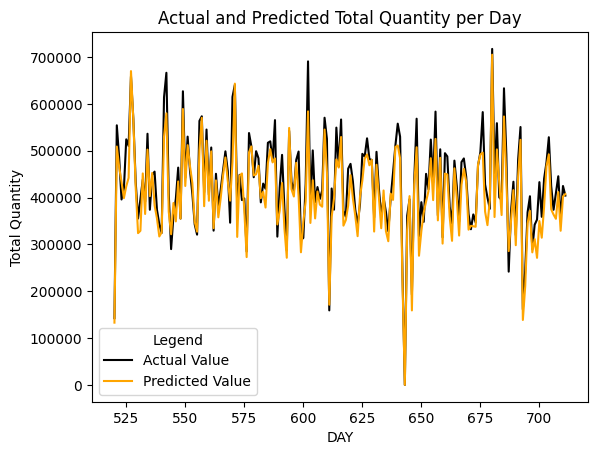

In [ ]:
# Combine the actual and prediction value
ml_result = X_out_sample
ml_result['actual'] = y_out_sample
ml_result['prediction'] = np.round(y_out_sample_pred)

ml_result_agg = ml_result.groupby('DAY', as_index=False).agg({'actual':'sum','prediction':'sum'})


# Plot the result
plt.figure(figsize=(12, 4))
sns.lineplot(data=ml_result_agg, x='DAY', y='actual',color='black',label='Actual Value')
sns.lineplot(data=ml_result_agg, x='DAY', y='prediction',color='orange', label='Predicted Value')
plt.title('Actual and Predicted Total Quantity per Day')
plt.ylabel('Total Quantity')
plt.legend(title='Legend')

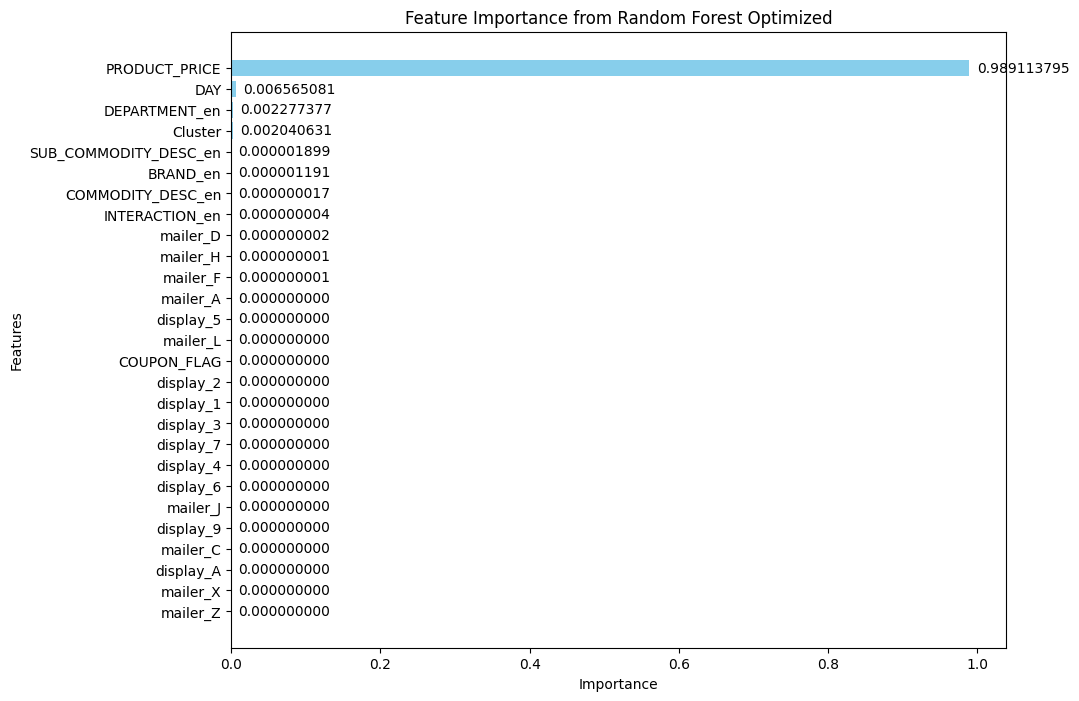

In [129]:
# Plot Feature Importance

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': insample_model.feature_names_in_,
    'Importance': insample_model.feature_importances_
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')

# Annotate the bars with their values
for bar in bars:
    plt.text(
        bar.get_width() + 0.01,  # Slightly offset to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically within the bar
        f'{bar.get_width():.9f}',  # Format the importance value with 2 decimal places
        va='center'  # Vertical alignment to center
    )

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Optimized')
plt.gca().invert_yaxis()  # To display the most important features on top
plt.show()


In [ ]:
# Show Value of Feature Importance
importance_df

Feature    Importance
1           PRODUCT_PRICE  9.723821e-01
0                     DAY  2.335449e-02
3                 Cluster  2.138232e-03
22          DEPARTMENT_en  2.122477e-03
24  SUB_COMMODITY_DESC_en  1.541656e-06
25               BRAND_en  1.107070e-06
23      COMMODITY_DESC_en  3.028396e-08
26         INTERACTION_en  7.717085e-09
15               mailer_D  2.629769e-09
17               mailer_H  1.156623e-09
13               mailer_A  1.053179e-09
8               display_5  8.809680e-10
16               mailer_F  8.060498e-10
2             COUPON_FLAG  5.273472e-10
4               display_1  4.650616e-10
5               display_2  3.990109e-10
6               display_3  3.119428e-10
10              display_7  2.617649e-10
19               mailer_L  1.996485e-10
7               display_4  1.649891e-10
9               display_6  1.568920e-10
11              display_9  1.540130e-10
18               mailer_J  6.115510e-11
12              display_A  5.042976e-11
14               mailer_C  1.651775e-11
20               mailer_X  4.896175e-13
21               mailer_Z  2.982362e-16

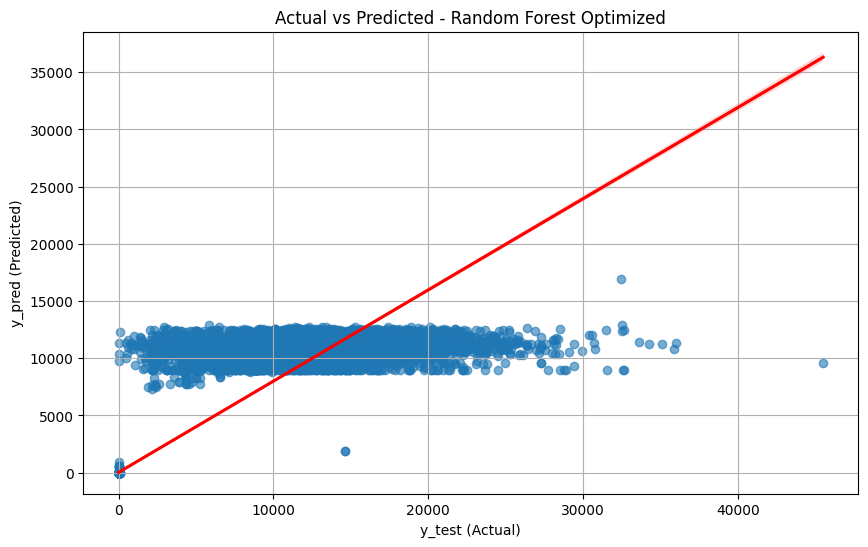

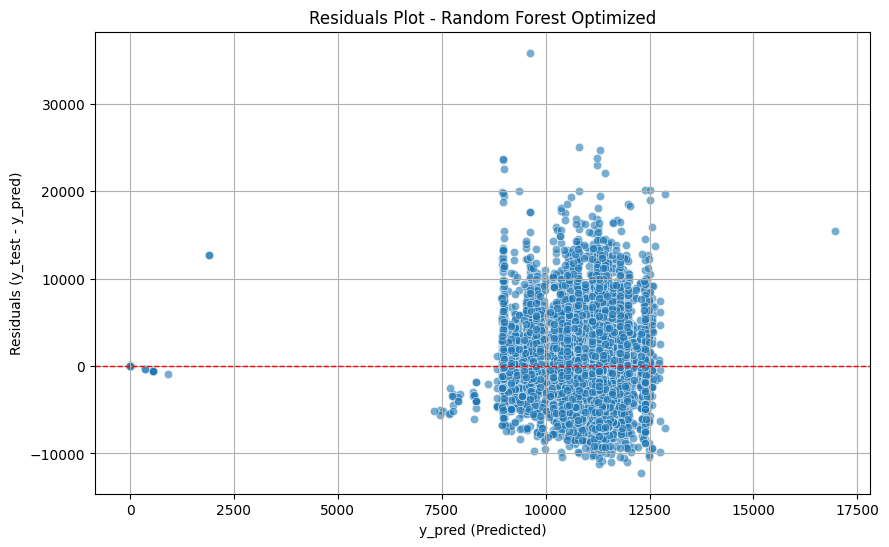

In [130]:
# Plot Residuals
# Visualization Result

# Scatter plot with regression line for y_test vs. y_pred
plt.figure(figsize=(10, 6))
sns.regplot(x=ml_result['actual'], y=ml_result['prediction'], scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})
plt.title("Actual vs Predicted - Random Forest Optimized")
plt.xlabel("y_test (Actual)")
plt.ylabel("y_pred (Predicted)")
plt.grid(True)
plt.show()

# Calculate residuals
residuals = ml_result['actual'] - ml_result['prediction']

# Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ml_result['prediction'], y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals Plot - Random Forest Optimized")
plt.xlabel("y_pred (Predicted)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.grid(True)
plt.show()


In [131]:
# Save the model

import joblib


joblib.dump(insample_model, "random_forest_opt.joblib")


['random_forest_opt.joblib']

<a id="conclusion"></a>
<h2>Conclusion</h2>

This report revolves around answering the question “Can the placement of products predict their sales volume? Moreover, does this relationship differ between in-store placements versus brochure placements or between product categories?”. Through building a base model and an RF algorithm afterwards, the model suggests that the placement of products cannot necessarily predict sales volume. This is due to other variables that the model deems to be more important, such as price, day, department, cluster, and sub-commodity description. Product category is the strongest predictor of sales volume, followed by in-store displays, which have more impact than brochures. However, using both displays and brochures together performs better.
Limitations within the data must be considered as they may influence result reliability. To improve future predictions and models, several additional data might be required:
1.	The exact timing and date to better understand the seasonality of the transaction pattern regarding the month and week. This would allow for possible seasonal promotions such as Christmas deals. 
2.	Comprehensive placement information for mailer and display as the current missing value can be considered extensive. This will allow for more accurate model predictions.
3.	In-depth store-specific information for all the grocery stores under the same company would give additional information such as location, size of the store, etc. This would in turn allow the model to take all this information into account and produce a better-tailored placement strategy for the store executives for each specific store. 
